# Digit Recognizer 🔢

---

### Group Members:

- **Mohamed Amine Tlili**  
- **Mohamed Aziz Loukil**  
- **Mohamed Laatar**

---

## Importing Libraries 📚

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from keras.regularizers import l2
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

## Loading Data 📥


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
df = train.copy()
df_test = test.copy()

In [3]:
df.describe()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
count,42000.000000,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,42000.0,...,42000.000000,42000.000000,42000.000000,42000.00000,42000.000000,42000.000000,42000.0,42000.0,42000.0,42000.0
mean,4.456643,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.219286,0.117095,0.059024,0.02019,0.017238,0.002857,0.0,0.0,0.0,0.0
std,2.887730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.312890,4.633819,3.274488,1.75987,1.894498,0.414264,0.0,0.0,0.0,0.0
min,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
25%,2.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
50%,4.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
75%,7.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.0
max,9.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,254.000000,254.000000,253.000000,253.00000,254.000000,62.000000,0.0,0.0,0.0,0.0


We can see there is one column that has the label and the rest are the image pixels!

In [4]:
#check for any missing values in train data
df.isnull().any().sum()

np.int64(0)

In [5]:
#check for any missing values in test data
df_test.isnull().any().sum()

np.int64(0)

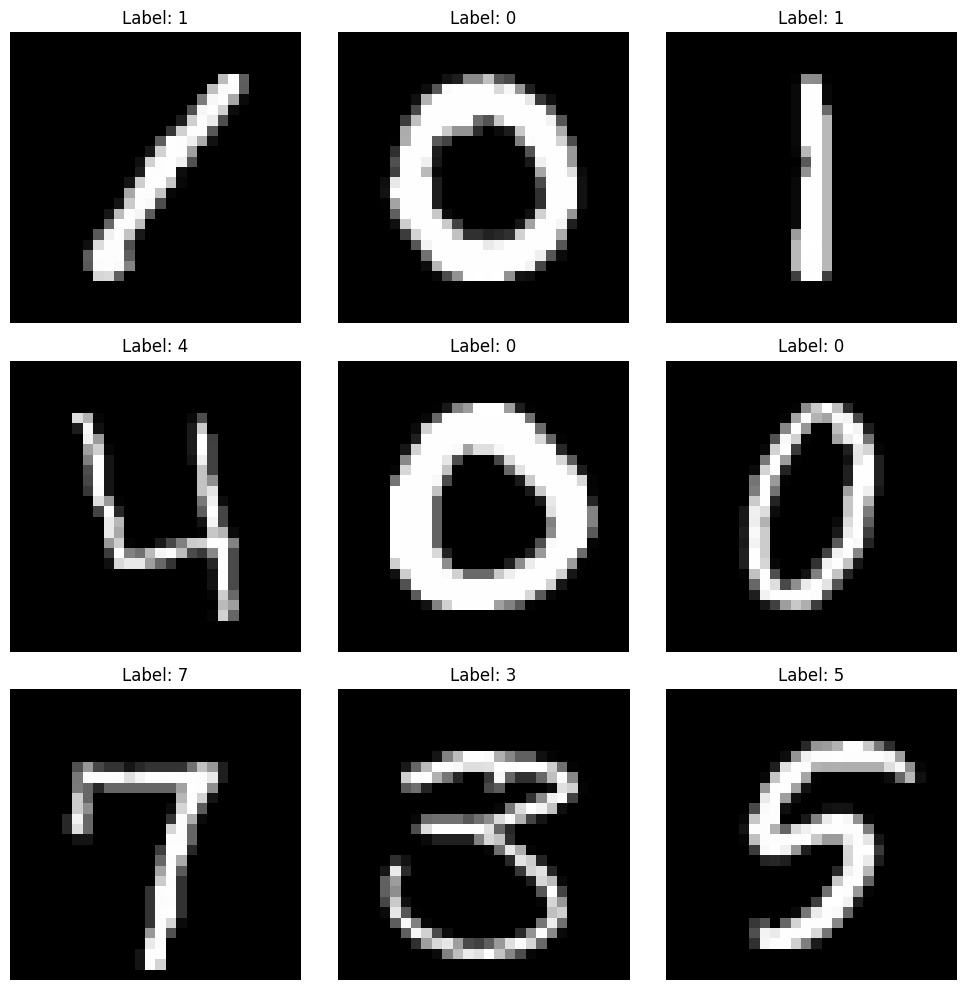

In [6]:
labels = train['label']
pixels = train.drop(columns=['label'])

# Display a few images
plt.figure(figsize=(10, 10))
for i in range(9):  # Display 9 images (3x3 grid)
    plt.subplot(3, 3, i + 1)
    img = pixels.iloc[i].values.reshape(28, 28)  # Reshape 784 values to 28x28
    plt.imshow(img, cmap='gray')  # Display in grayscale
    plt.title(f"Label: {labels.iloc[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

C:\Users\Mohamed Aziz\AppData\Local\Temp\ipykernel_33836\3844086504.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=df, palette="viridis", edgecolor="black")


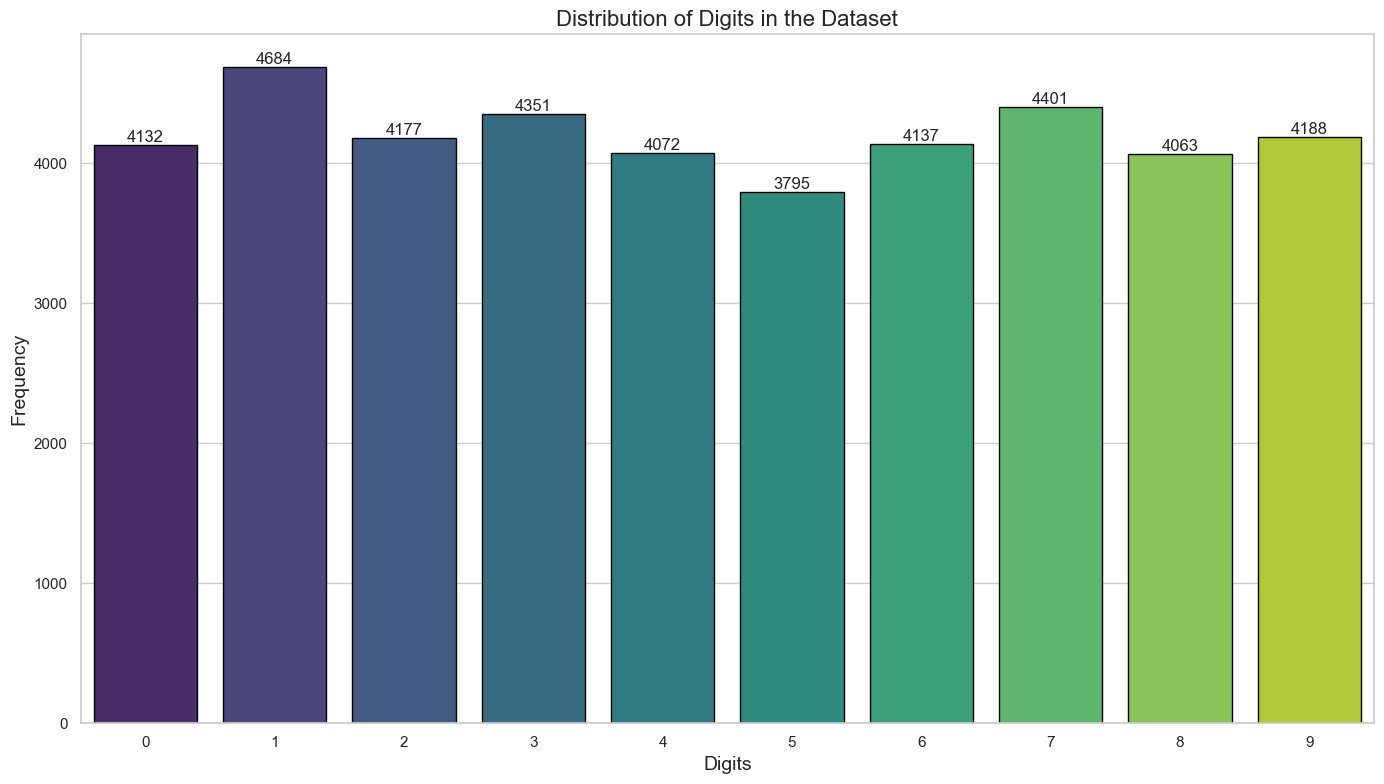

In [7]:
# Set the theme for Seaborn
sns.set_theme(style="whitegrid")

# Create the plot
plt.figure(figsize=(14, 8))
sns.countplot(x='label', data=df, palette="viridis", edgecolor="black")

# Add labels and title
plt.xlabel('Digits', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Distribution of Digits in the Dataset', fontsize=16)

# Add values on top of the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, fmt='%d', label_type='edge', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Data Preprocessing 🔍

- We set a random seed to ensure that results are consistent across multiple runs, especially for operations like data splitting and weight initialization.

In [8]:
## Setting the seeds for Reproducibility.
seed = 3141
np.random.seed(seed)

### Splitting Train and Test Data

- Separate pixel values (X) from image labels (Y) in the training data.

In [9]:
# X is the pixels and Y is the image labels
X = train.iloc[:,1:]
Y = train.iloc[:,0]

#splitting dataframe using train_test_split
x_train , x_test , y_train , y_test = train_test_split(X, Y , test_size=0.1, random_state=seed)

### Reshaping Images

- We have a 1D vector with 784 pixels and we have to reshape it to (28x28x1).

- This is because Keras wants an Extra Dimension in the end for channels. If this had been RGB images, there would have been 3 channels, but as MNIST is gray scale it only uses 1.

In [10]:
#first param in reshape is number of examples. We can pass -1 here as we want numpy to figure that out by itself

#reshape(examples, height, width, channels)
x_train = x_train.values.reshape(-1, 28, 28, 1)
x_test = x_test.values.reshape(-1, 28, 28, 1)
df_test=df_test.values.reshape(-1,28,28,1)

### Data Augmentation

Data augmentation is super important.  In terms of Images it means we can increase the number of images our model sees.

This can be acheived by Rotating the Image, Flipping the Image, Zooming the Image, Changing light conditions, Cropping it etc.

Keep in mind doing all these things will not always help the model. For example in our situation a vertical_flip would not be wise as 6's would become 9's and vice-versa.

In [11]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images

### Normalization

- Pixel values are normalized to the range [0, 1] by dividing by 255. This speeds up convergence during training and improves numerical stability.

In [12]:
#convert values to float as result will be a float. If not done vals are set to zero
x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255
df_test = df_test.astype("float32")/255

In [13]:
x_train.shape

(37800, 28, 28, 1)

In [14]:
#fitting the ImageDataGenerator we defined above
datagen.fit(x_train)

### One hot encoding labels

The labels are given as integers between 0-9. We need to one hot encode them.

For example 4 looks like this: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]

This is done so that we have labels for all the classes, and we can easily carry out the Error/Cost during BackPropogation.



In [15]:
#notice num_classes is set to 10 as we have 10 different labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


# Building CNN Model

For image classification CNN's are the best

We construct a CNN with:

- Convolutional Layers: Extract spatial features.
- Batch Normalization: Stabilize training.
- Pooling Layers: Down-sample feature maps.
- Dropout: Prevent overfitting.
- Fully Connected Layers: Combine features for classification.

In [16]:
#Conv2d data_format parameter we use 'channel_last' for imgs

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',
                 input_shape=(28,28,1)))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='valid' ))
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), padding='valid', strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## Compiling Model (configure learning process)

Adam Optimizer:

The Adam optimizer is widely used because it combines the advantages of two other optimizers, AdaGrad (adaptive learning rates for each parameter) and RMSProp (adaptive learning rates with momentum).

It’s efficient, requires minimal memory, and is well-suited for large datasets and complex models.
  
  Key Parameters:

- learning_rate=0.001: The initial step size for adjusting weights. A smaller learning rate ensures the optimizer takes cautious steps towards convergence.
- beta_1=0.9: The exponential decay rate for the first moment estimates (momentum). This helps smooth the gradient.
- beta_2=0.999: The exponential decay rate for the second moment estimates (variance). It helps in stabilizing the optimizer's steps.




In [17]:
from keras.optimizers import Adam

# Optimizer
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

In [18]:
#Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,213,610 (8.44 MB)

 Trainable params: 2,210,154 (8.43 MB)

 Non-trainable params: 3,456 (13.50 KB)

### Learning Rate Decay

Many optimization algorithms have a constant learning rate, which will often not reach a local minima.

To implement Learning Rate Decay we can use either LearningRateScheduler or ReduceLRonPlateau.

- LearningRateScheduler -  takes the step decay function as argument and returns updated learning rates for use in optimzer at every epoch stage.

- ReduceLRonPlateau  - monitors a quantity and if no improvement is seen for a 'patience' number of epochs, then the learning rate is reduced by a factor specified manually.

In [20]:
#for our case LearningRateScheduler will work great
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [21]:
#visualizing what the learning rate decay will do to the learning rate through every epoch
decays = [(lambda x: 1e-3 * 0.9 ** x)(x) for x in range(10)]
i=1

for lr in decays:
    print("Epoch " + str(i) +" Learning Rate: " + str(lr))
    i+=1

Epoch 1 Learning Rate: 0.001
Epoch 2 Learning Rate: 0.0009000000000000001
Epoch 3 Learning Rate: 0.0008100000000000001
Epoch 4 Learning Rate: 0.0007290000000000002
Epoch 5 Learning Rate: 0.0006561000000000001
Epoch 6 Learning Rate: 0.00059049
Epoch 7 Learning Rate: 0.000531441
Epoch 8 Learning Rate: 0.0004782969000000001
Epoch 9 Learning Rate: 0.0004304672100000001
Epoch 10 Learning Rate: 0.0003874204890000001


### Early Stopping Rounds

- We would still like to define an early stopping parameter to ensure that our model stops training once we have reached a point where it is no longer necessary to continue training. This is another way to control overfitting.

- Its important to note that we need to specify a validation dataset in the model to use an early_stopping callback

In [22]:
#by default this is evaluated on 'val_loss'
early_stopping = EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

Since we have the LearningRateScheduler, if we dont use the early stopping callback in this model we see an improvement from 96.4% to about 96.6% accuracy as we get closer and closer to the local minima.

## Fitting the Model

In [23]:
#defining these prior to model to increase readability and debugging
batch_size = 64
epochs = 10

In [24]:
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[reduce_lr]
)

Epoch 1/10


c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.7841 - loss: 0.7627 - val_accuracy: 0.9474 - val_loss: 0.1663 - learning_rate: 0.0010
Epoch 2/10
  1/590 ━━━━━━━━━━━━━━━━━━━━ 31s 53ms/step - accuracy: 0.9531 - loss: 0.1476

c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9531 - loss: 0.1476 - val_accuracy: 0.9474 - val_loss: 0.1668 - learning_rate: 9.0000e-04
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 32s 55ms/step - accuracy: 0.9573 - loss: 0.1429 - val_accuracy: 0.9845 - val_loss: 0.0563 - learning_rate: 8.1000e-04
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.2002 - val_accuracy: 0.9845 - val_loss: 0.0559 - learning_rate: 7.2900e-04
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9689 - loss: 0.1008 - val_accuracy: 0.9888 - val_loss: 0.0405 - learning_rate: 6.5610e-04
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.0633 - val_accuracy: 0.9893 - val_loss: 0.0400 - learning_rate: 5.9049e-04
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 38s 64ms/step - accuracy: 0.9757 - loss: 0.0759 - val_accuracy: 0.9905 - val_loss: 0.0296 - learning_rate: 5.3144e-04
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.968

### Evaluating the model

In [25]:
import matplotlib.pyplot as plt

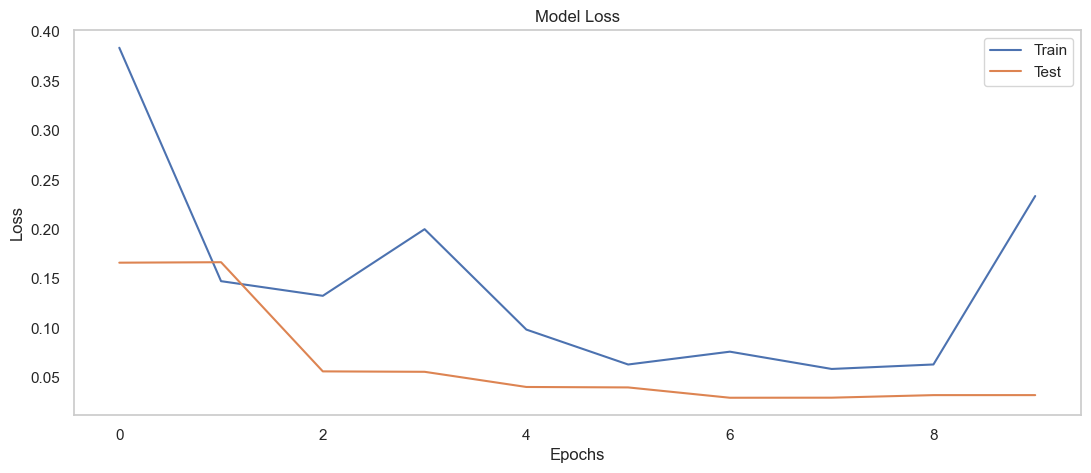

In [26]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'])
plt.grid()
plt.show()

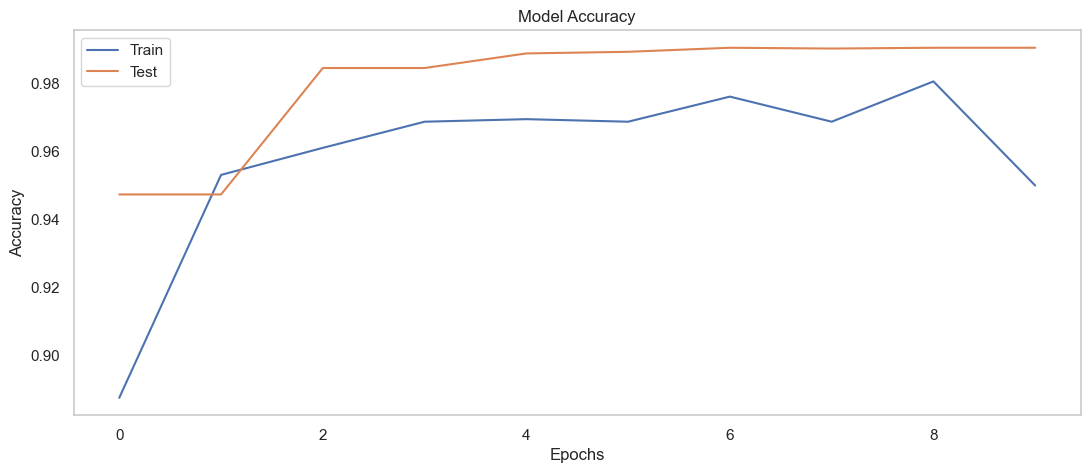

In [27]:
plt.figure(figsize=(13, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train','Test'])
plt.grid()
plt.show()

Since the validation_accuracy and the accuracy are really close together we can conclude that we are not overfitting the data.

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


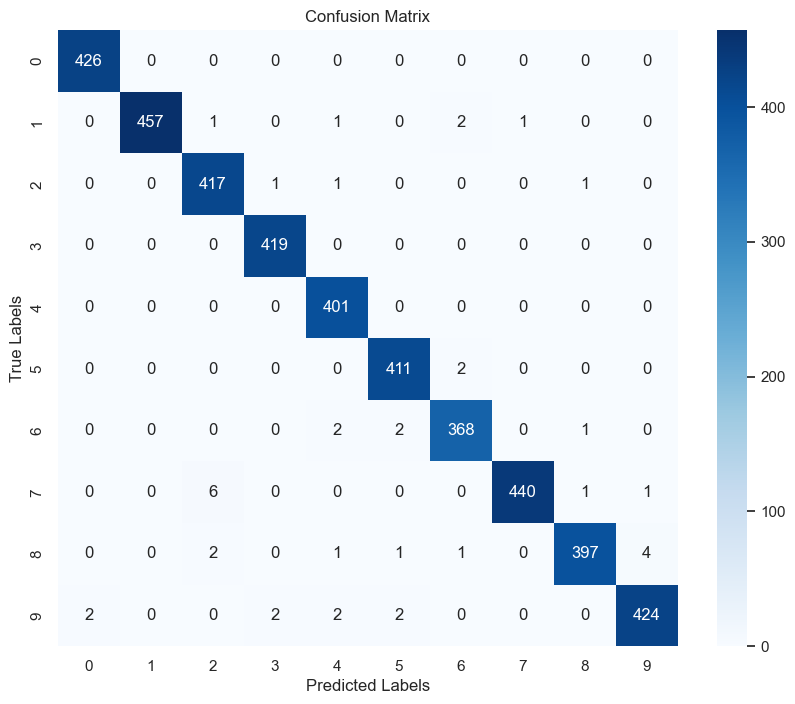

In [28]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
y_pred = np.argmax(model.predict(x_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [29]:
x_train.shape

(37800, 28, 28, 1)

In [32]:
# The probabilites of each class were calculated for each image.
prob_pred = model.predict(x_test)

# The class that has the highest probability will be likeyly the answer.
# Get classes predicted by the model
y_pred = prob_pred.argmax(-1)
# Get true classes
y_true = np.where(y_test == 1)[1]

132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [33]:
# Get ID of tests with wrong predictions
id_error_tests = (y_pred - y_true != 0)

# Get the predicted labels for error tests
pred_label_error_tests = y_pred[id_error_tests]
# Get the true labels for error tests
true_label_error_tests = y_true[id_error_tests]
# Get the error tests out of initial tests
error_tests = x_test[id_error_tests]

# Probabilities for all classes in error tests
pred_prob_error_tests = prob_pred[id_error_tests]
# Probabilities for predicted class only in error tests
pred_label_prob_error_tests = np.max(pred_prob_error_tests, axis = 1)
# Probabilities for true class only in error tests
true_label_prob_error_tests = np.diagonal(np.take(pred_prob_error_tests, true_label_error_tests, axis = 1))

# Delta of probabilities between true and predicted labels in error tests
delta_prob_error_tests = pred_label_prob_error_tests - true_label_prob_error_tests
# Get id of 10 error tests with greatest difference in probabilities
id_10_greatest_differences_error_tests = np.argsort(delta_prob_error_tests)[-10:]

In [34]:
def to_rgb(image):
    # Convert from (28, 28) or (28, 28, 1) to (28, 28, 3)
    return np.repeat(image[..., np.newaxis], 3, axis=-1)

In [35]:
def to_rgb(image):
    """Convert grayscale (28, 28, 1) → RGB (28, 28, 3)"""
    # Remove singleton dimensions (e.g., (28, 28, 1) → (28, 28))
    image = np.squeeze(image)
    # Add RGB channels
    return np.stack([image] * 3, axis=-1)  # Shape: (28, 28, 3)

In [36]:
print("Original shape:", error_tests[i].shape)

Original shape: (28, 28, 1)


In [37]:
img_rgb = to_rgb(error_tests[i])
print("RGB shape:", img_rgb.shape)

RGB shape: (28, 28, 3)


In [38]:
print(img_rgb.shape)  # Should output (28, 28, 3)

(28, 28, 3)


In [39]:
def model_predict(img):
    """Convert RGB → grayscale for model inference"""
    # Input shape: (n_samples, 28, 28, 3)
    grayscale = img[:, :, :, 0]  # Use first channel (all are same for grayscale)
    grayscale = grayscale.reshape(-1, 28, 28, 1)  # Reshape to (n, 28, 28, 1)
    return model.predict(grayscale)

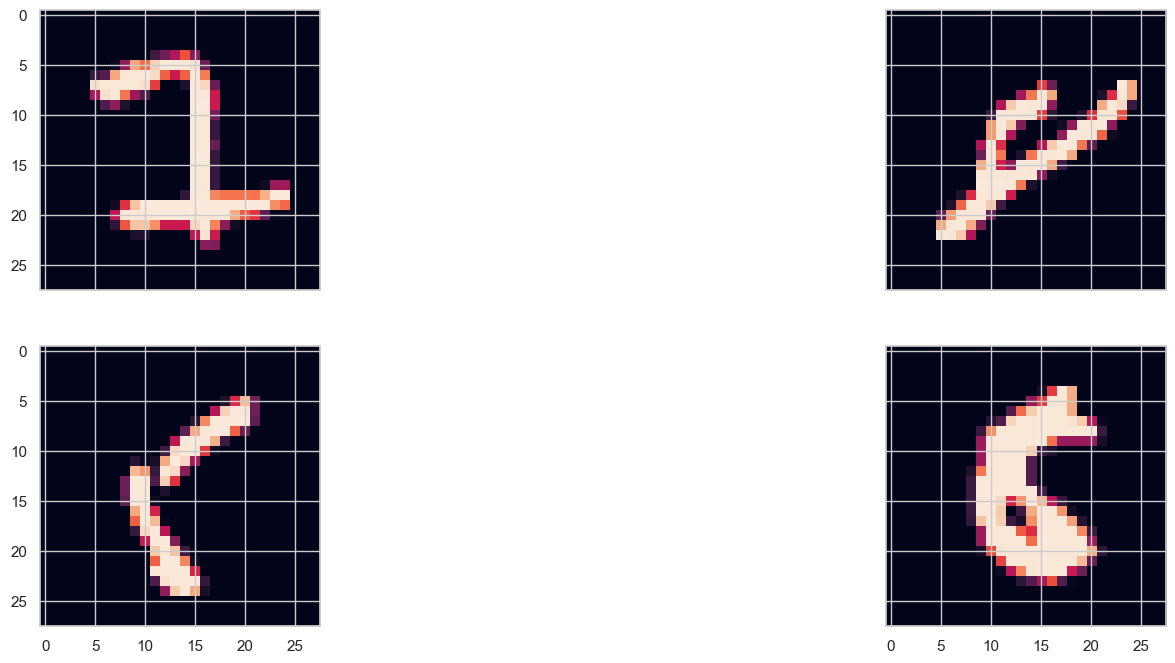

In [40]:
n = 0
nrows = 2
ncols = 2

fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey= True, figsize = (20,8))

for row in range(nrows):
    for col in range(ncols):
        ax[row, col].imshow(error_tests[id_10_greatest_differences_error_tests[n]].reshape((28, 28,1)))
      
        n += 1

plt.show()

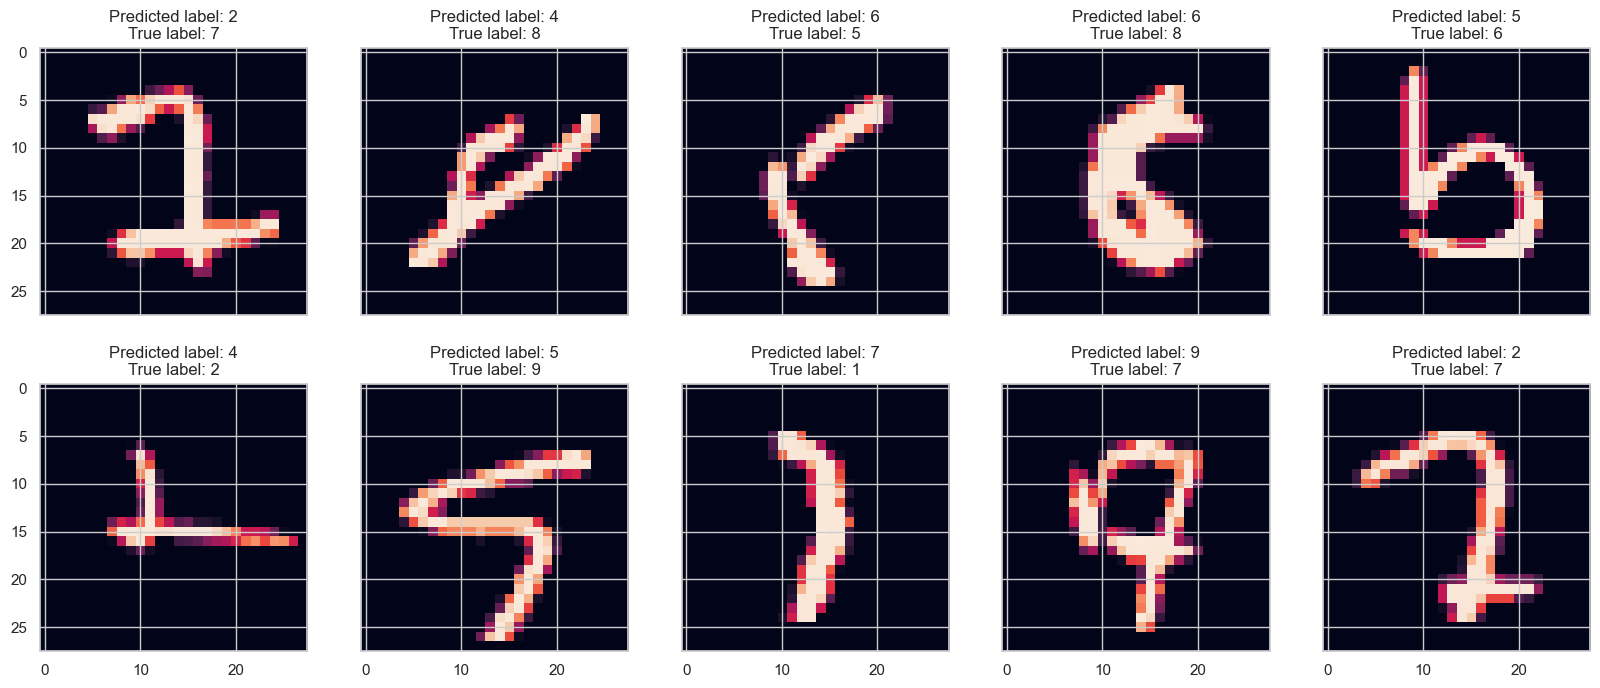

In [41]:
def show_10_error_tests(id, img, pred_labels, true_labels):
    n = 0
    nrows = 2
    ncols = 5

    fig, ax = plt.subplots(nrows, ncols, sharex = True, sharey= True, figsize = (20,8))

    for row in range(nrows):
        for col in range(ncols):
            ax[row, col].imshow(img[id[n]].reshape((28, 28,1)))
            ax[row, col].set_title("Predicted label: {}\nTrue label: {}".format
                                  (pred_labels[id[n]], true_labels[id[n]]))
            n += 1

    plt.show()

show_10_error_tests(id_10_greatest_differences_error_tests,
                    error_tests,
                    pred_label_error_tests,
                    true_label_error_tests)

In [42]:
id_10_greatest_differences_error_tests

array([37, 26,  3, 39, 16, 12, 13,  4, 25, 10])

In [43]:
x_test.shape

(4200, 28, 28, 1)

In [44]:
x_train.shape

(37800, 28, 28, 1)

In [45]:
error_tests.shape

(40, 28, 28, 1)

### SHAP (SHapley Additive exPlanations)

c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(1, 28, 28, 1))']
  warnings.warn(msg)


Predicted label :2
True label :7


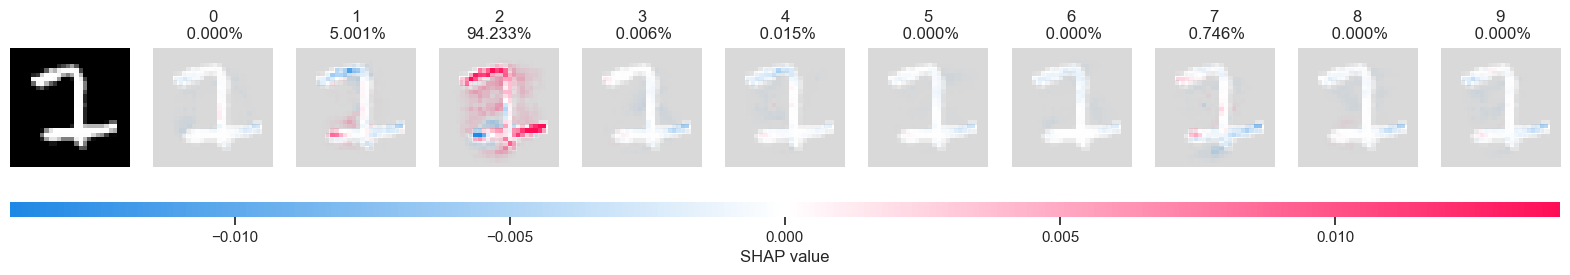

Predicted label :4
True label :8


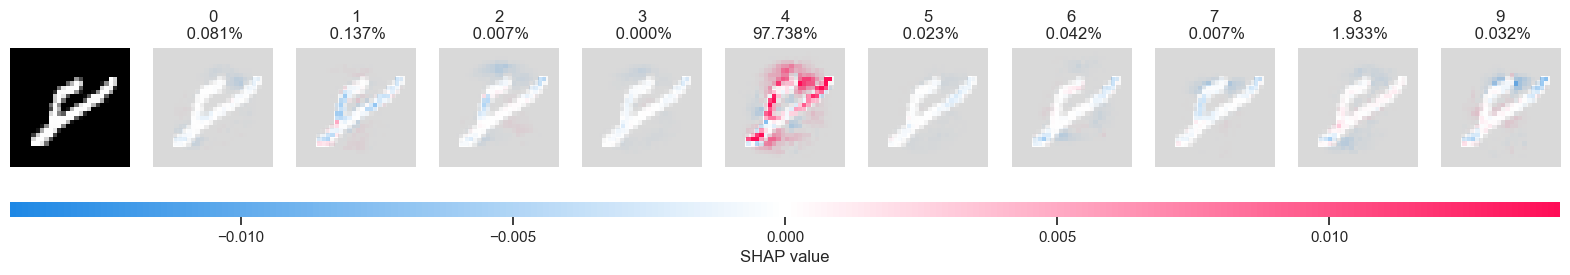

Predicted label :6
True label :5


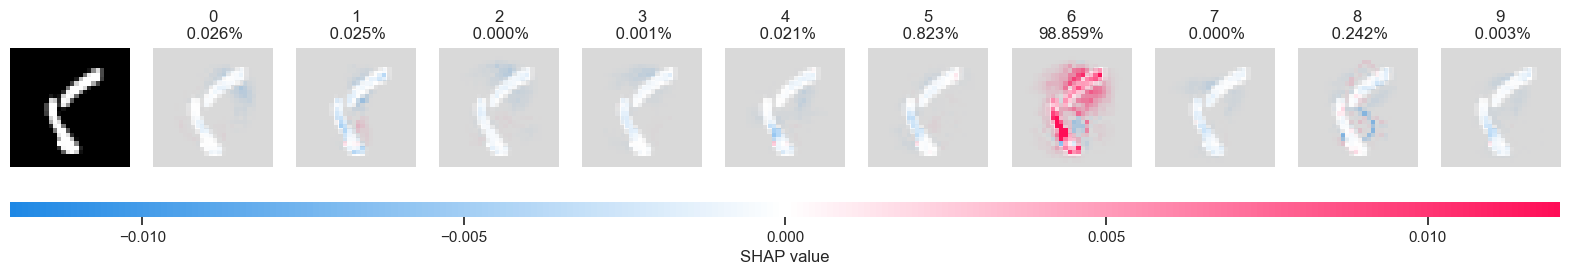

Predicted label :6
True label :8


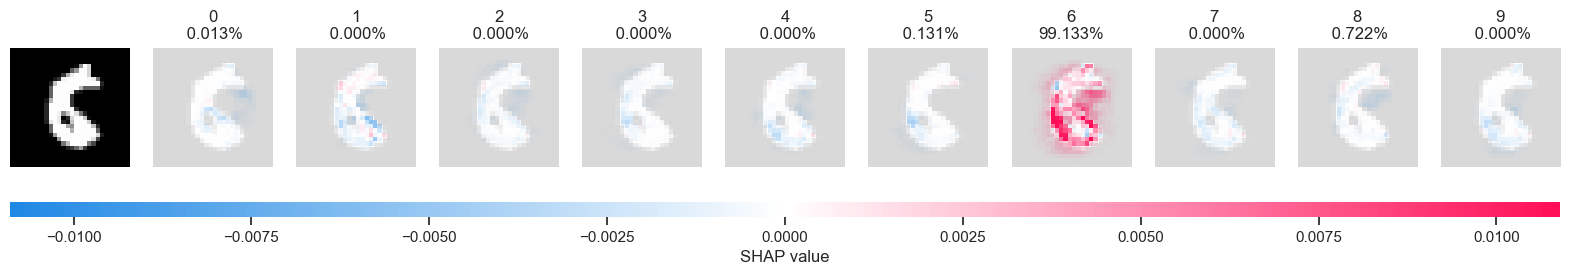

Predicted label :5
True label :6


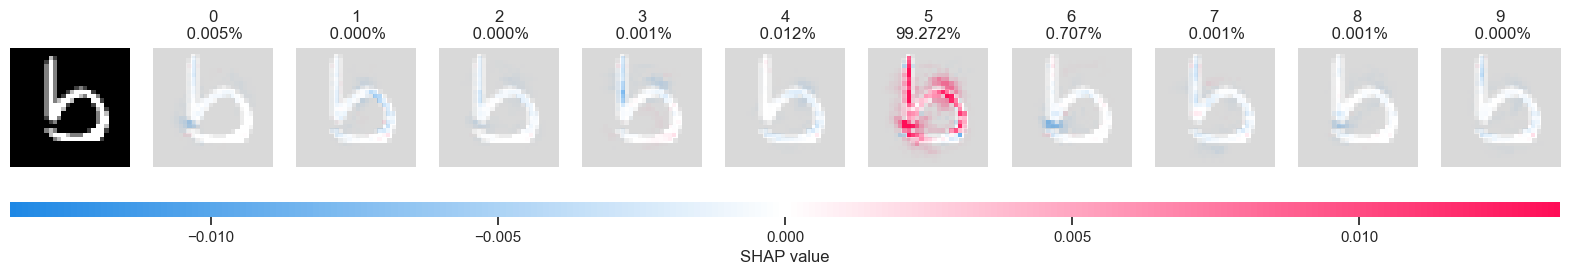

Predicted label :4
True label :2


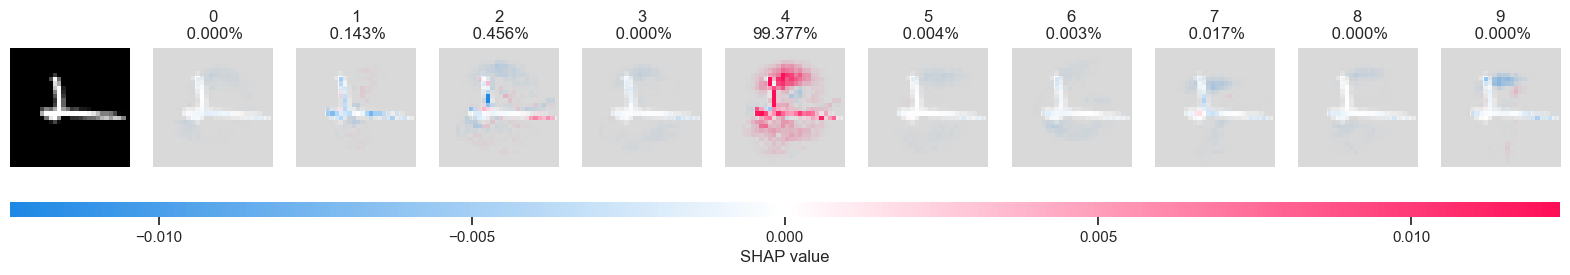

Predicted label :5
True label :9


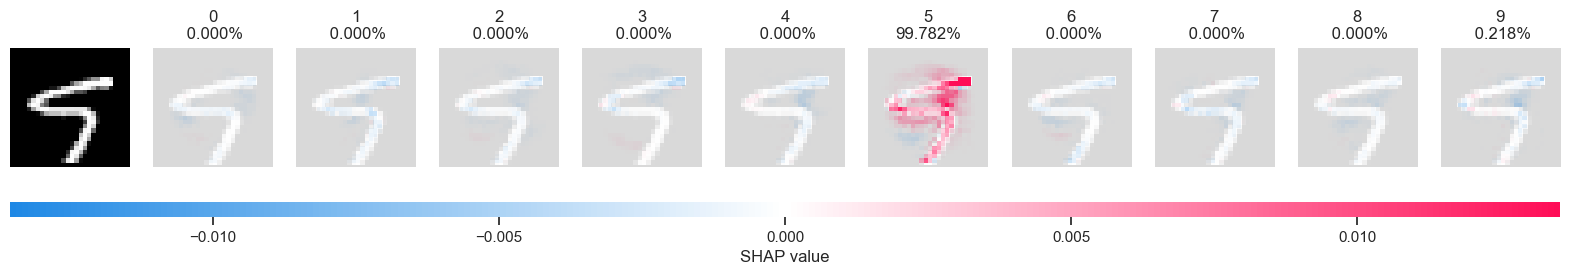

Predicted label :7
True label :1


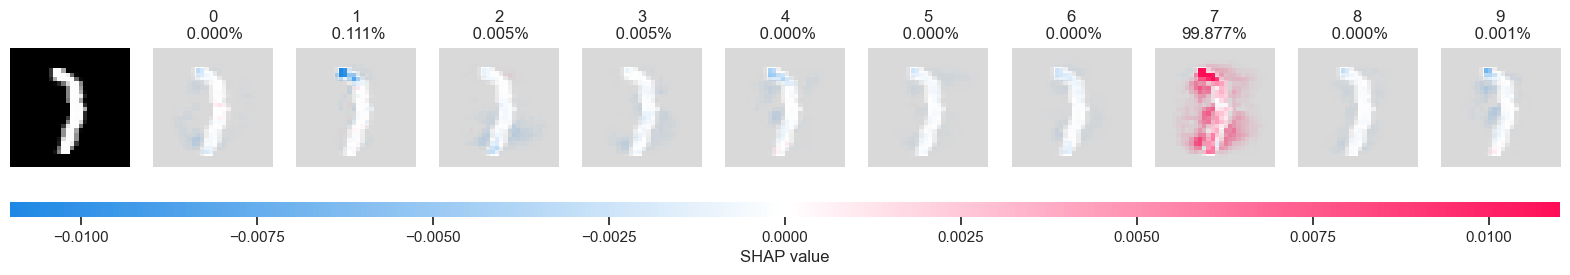

Predicted label :9
True label :7


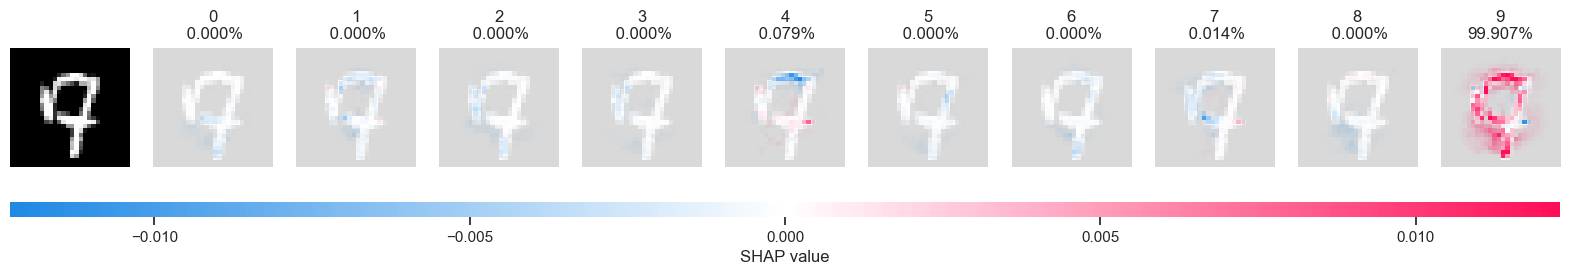

Predicted label :2
True label :7


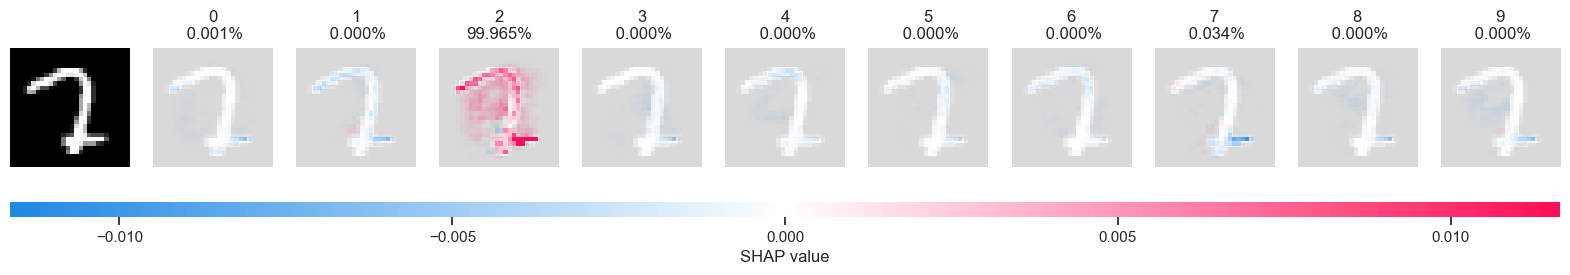

In [46]:
import shap

# Intializae
explainer = shap.DeepExplainer(model, (x_train[0:1000]))

for id_test in id_10_greatest_differences_error_tests:
    # Get SHap values
    shap_values = explainer.shap_values(error_tests[[id_test]])

    index_names = np.array([str(x) + "\n" + '{:>7.3%}'.format
                            (pred_prob_error_tests[id_test][x]) for x in range(10)]).reshape(1,10)
    print("Predicted label :{}\nTrue label :{}".format
          (pred_label_error_tests[id_test],true_label_error_tests[id_test]))
    
    shap_values_corrected = [shap_values[..., i] for i in range(10)]
    # Plot
    shap.image_plot(shap_values_corrected, error_tests[[id_test]], index_names, show = False)
    plt.show()

c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(100, 28, 28, 1))']
  warnings.warn(msg)
c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(200, 28, 28, 1))']
  warnings.warn(msg)
c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(6, 28, 28, 1))']
  warnings.warn(msg)


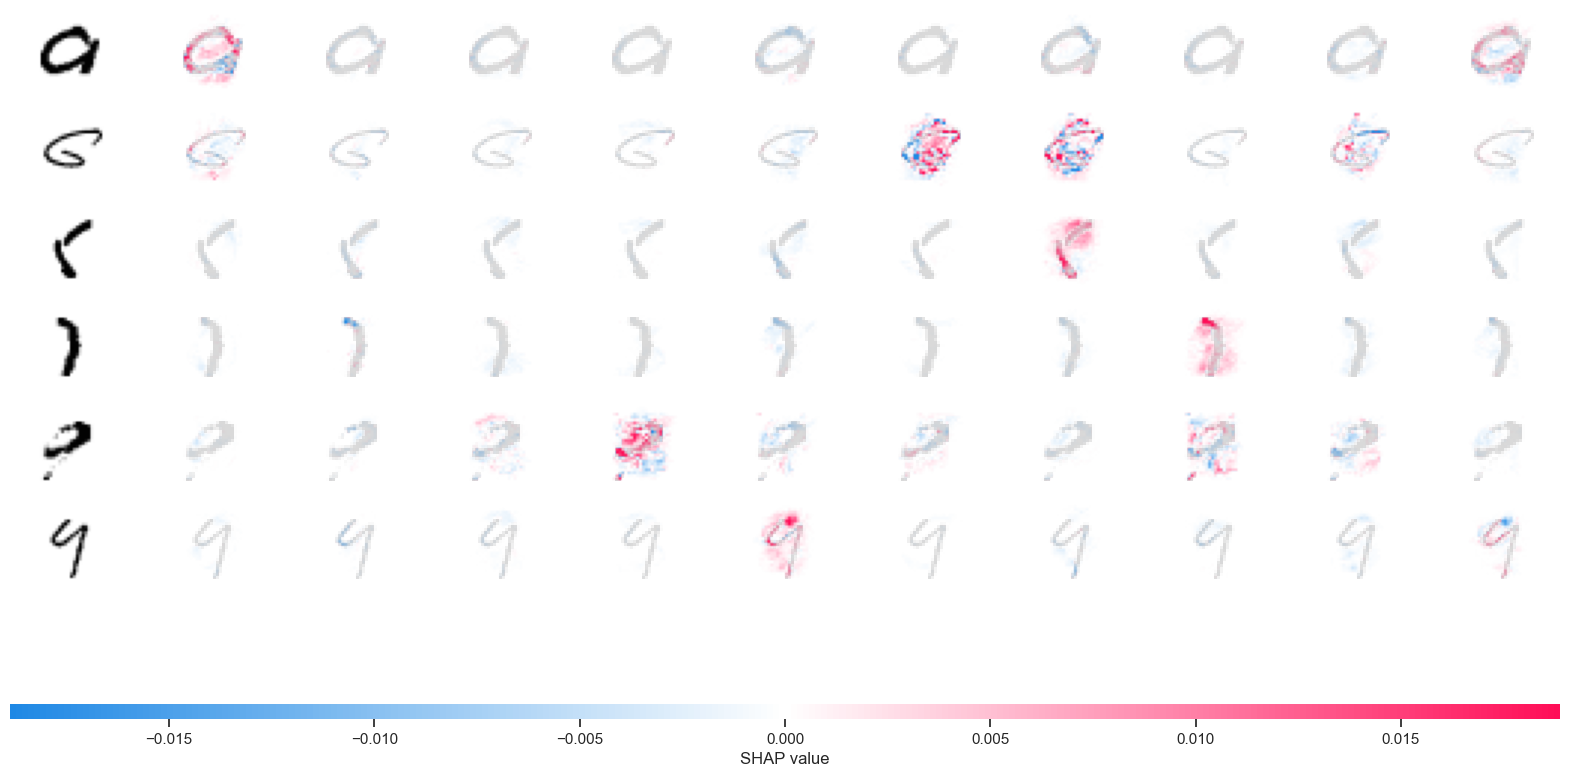

In [47]:
import shap
import numpy as np

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]

# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)

shap_values = e.shap_values(error_tests[1:7])

shap_values_corrected = [shap_values[..., i] for i in range(10)]
shap.image_plot(shap_values_corrected, -error_tests[1:7])

In [48]:
print(len(shap_values))  # Should print 10 for 10 classes
print(np.array(shap_values).shape)  # Should be (10, batch_size, height, width, channels)

6
(6, 28, 28, 1, 10)


In [ ]:
#!pip install aix360
#!pip install lime

### LIME (Local Interpretable Model-Agnostic Explanations)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 20/1000 [00:00<00:07, 124.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 40/1000 [00:00<00:07, 129.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 60/1000 [00:00<00:07, 125.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


  8%|▊         | 80/1000 [00:00<00:07, 130.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 10%|█         | 100/1000 [00:00<00:07, 124.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 120/1000 [00:00<00:07, 124.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 14%|█▍        | 140/1000 [00:01<00:06, 127.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 16%|█▌        | 160/1000 [00:01<00:06, 122.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 18%|█▊        | 180/1000 [00:01<00:06, 123.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 20%|██        | 200/1000 [00:01<00:06, 122.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|██▏       | 220/1000 [00:01<00:06, 113.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 23%|██▎       | 232/1000 [00:01<00:06, 112.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 25%|██▌       | 250/1000 [00:02<00:07, 106.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 261/1000 [00:02<00:06, 107.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 28%|██▊       | 280/1000 [00:02<00:06, 103.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 29%|██▉       | 291/1000 [00:02<00:06, 103.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 30%|███       | 302/1000 [00:02<00:06, 103.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███▏      | 313/1000 [00:02<00:06, 104.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 32%|███▏      | 324/1000 [00:02<00:06, 105.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 34%|███▎      | 335/1000 [00:02<00:06, 106.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 35%|███▌      | 350/1000 [00:03<00:06, 95.58it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 37%|███▋      | 370/1000 [00:03<00:06, 99.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 390/1000 [00:03<00:05, 104.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 40%|████      | 401/1000 [00:03<00:05, 103.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 41%|████      | 412/1000 [00:03<00:05, 104.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 430/1000 [00:03<00:05, 104.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▌     | 450/1000 [00:04<00:05, 107.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 47%|████▋     | 470/1000 [00:04<00:04, 106.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 49%|████▉     | 490/1000 [00:04<00:04, 109.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 50%|█████     | 501/1000 [00:04<00:04, 106.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 512/1000 [00:04<00:04, 106.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 53%|█████▎    | 530/1000 [00:04<00:04, 106.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 55%|█████▌    | 550/1000 [00:04<00:03, 114.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 57%|█████▋    | 570/1000 [00:05<00:03, 116.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 59%|█████▉    | 590/1000 [00:05<00:03, 119.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 610/1000 [00:05<00:03, 120.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 63%|██████▎   | 630/1000 [00:05<00:03, 123.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▌   | 650/1000 [00:05<00:02, 123.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 67%|██████▋   | 670/1000 [00:05<00:02, 117.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 69%|██████▉   | 690/1000 [00:06<00:02, 111.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 710/1000 [00:06<00:02, 111.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 730/1000 [00:06<00:02, 114.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 75%|███████▌  | 750/1000 [00:06<00:02, 116.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 77%|███████▋  | 770/1000 [00:06<00:01, 120.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 79%|███████▉  | 790/1000 [00:06<00:01, 123.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 81%|████████  | 810/1000 [00:07<00:01, 121.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 830/1000 [00:07<00:01, 118.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 850/1000 [00:07<00:01, 118.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 87%|████████▋ | 870/1000 [00:07<00:01, 118.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 89%|████████▉ | 890/1000 [00:07<00:00, 118.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 91%|█████████ | 910/1000 [00:07<00:00, 120.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 93%|█████████▎| 930/1000 [00:08<00:00, 123.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 95%|█████████▌| 950/1000 [00:08<00:00, 124.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 97%|█████████▋| 970/1000 [00:08<00:00, 124.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 99%|█████████▉| 990/1000 [00:08<00:00, 123.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|██████████| 1000/1000 [00:08<00:00, 115.31it/s]


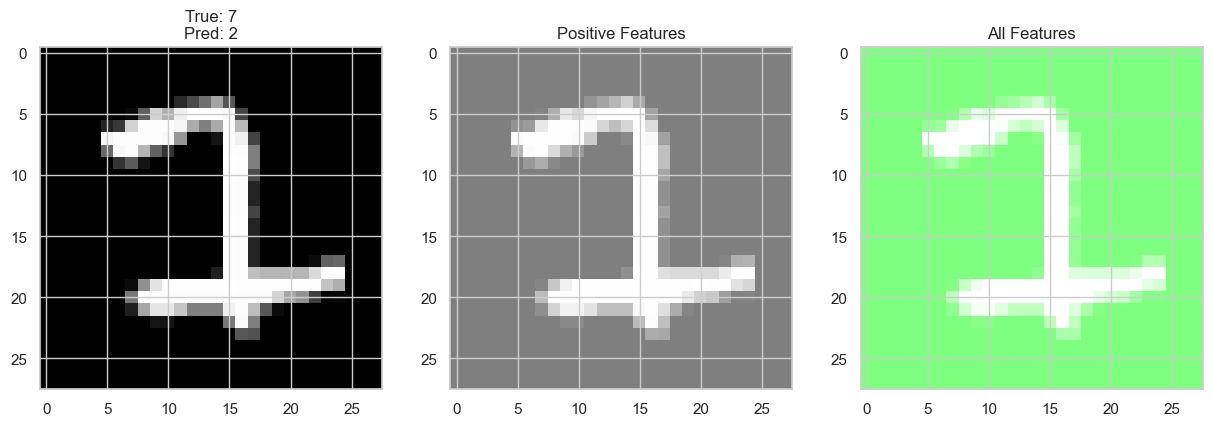

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  2%|▏         | 20/1000 [00:00<00:08, 120.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  4%|▍         | 40/1000 [00:00<00:07, 127.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


  6%|▌         | 60/1000 [00:00<00:07, 124.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 80/1000 [00:00<00:07, 124.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 10%|█         | 100/1000 [00:00<00:07, 123.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 12%|█▏        | 120/1000 [00:00<00:06, 129.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 13%|█▎        | 134/1000 [00:01<00:06, 125.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 150/1000 [00:01<00:07, 111.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 17%|█▋        | 170/1000 [00:01<00:06, 118.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 190/1000 [00:01<00:06, 119.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 21%|██        | 210/1000 [00:01<00:06, 124.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 23%|██▎       | 230/1000 [00:01<00:05, 130.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 25%|██▌       | 250/1000 [00:01<00:05, 135.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 27%|██▋       | 270/1000 [00:02<00:05, 136.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 28%|██▊       | 284/1000 [00:02<00:05, 133.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 30%|███       | 300/1000 [00:02<00:05, 116.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 320/1000 [00:02<00:05, 124.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 34%|███▍      | 340/1000 [00:02<00:05, 131.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 360/1000 [00:02<00:04, 138.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 380/1000 [00:02<00:04, 141.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|████      | 400/1000 [00:03<00:04, 146.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 42%|████▏     | 420/1000 [00:03<00:03, 148.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 440/1000 [00:03<00:03, 149.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 46%|████▌     | 460/1000 [00:03<00:03, 150.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 48%|████▊     | 480/1000 [00:03<00:03, 150.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 50%|█████     | 500/1000 [00:03<00:03, 149.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 520/1000 [00:03<00:03, 149.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 54%|█████▍    | 540/1000 [00:04<00:03, 150.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 56%|█████▌    | 560/1000 [00:04<00:02, 152.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 580/1000 [00:04<00:02, 152.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 60%|██████    | 600/1000 [00:04<00:02, 152.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 62%|██████▏   | 620/1000 [00:04<00:02, 152.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 64%|██████▍   | 640/1000 [00:04<00:02, 151.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 66%|██████▌   | 660/1000 [00:04<00:02, 146.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 68%|██████▊   | 680/1000 [00:04<00:02, 141.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 700/1000 [00:05<00:02, 143.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 72%|███████▏  | 720/1000 [00:05<00:01, 145.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 740/1000 [00:05<00:01, 146.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 76%|███████▌  | 760/1000 [00:05<00:01, 148.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 78%|███████▊  | 780/1000 [00:05<00:01, 142.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 800/1000 [00:05<00:01, 143.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 82%|████████▏ | 820/1000 [00:05<00:01, 144.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 840/1000 [00:06<00:01, 147.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 860/1000 [00:06<00:00, 145.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 880/1000 [00:06<00:00, 145.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 90%|█████████ | 900/1000 [00:06<00:00, 145.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 920/1000 [00:06<00:00, 145.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 940/1000 [00:06<00:00, 146.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▌| 955/1000 [00:06<00:00, 143.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 97%|█████████▋| 970/1000 [00:07<00:00, 117.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 99%|█████████▉| 990/1000 [00:07<00:00, 123.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|██████████| 1000/1000 [00:07<00:00, 137.55it/s]


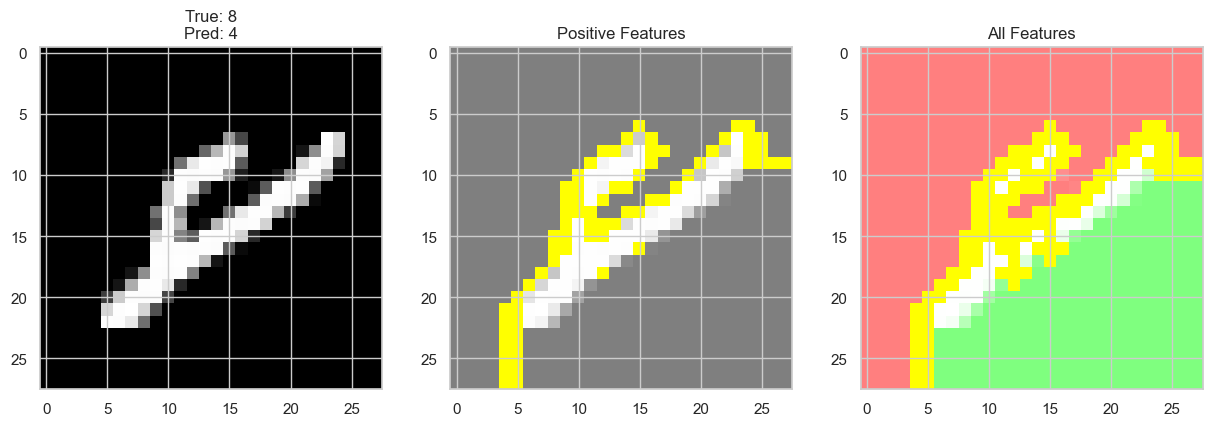

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


  2%|▏         | 20/1000 [00:00<00:09, 108.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 40/1000 [00:00<00:07, 127.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 60/1000 [00:00<00:06, 136.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  8%|▊         | 80/1000 [00:00<00:06, 137.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 100/1000 [00:00<00:06, 140.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 120/1000 [00:00<00:06, 139.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 140/1000 [00:01<00:06, 131.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|█▌        | 160/1000 [00:01<00:06, 123.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 18%|█▊        | 180/1000 [00:01<00:07, 113.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 19%|█▉        | 192/1000 [00:01<00:07, 114.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 21%|██        | 210/1000 [00:01<00:07, 108.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|██▎       | 230/1000 [00:01<00:07, 109.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 24%|██▍       | 242/1000 [00:02<00:06, 111.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 260/1000 [00:02<00:06, 107.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 280/1000 [00:02<00:06, 115.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 300/1000 [00:02<00:05, 121.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 32%|███▏      | 320/1000 [00:02<00:05, 124.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 34%|███▍      | 340/1000 [00:02<00:05, 131.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 360/1000 [00:02<00:04, 135.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 38%|███▊      | 380/1000 [00:03<00:04, 137.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 40%|████      | 400/1000 [00:03<00:04, 135.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 420/1000 [00:03<00:04, 128.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 440/1000 [00:03<00:04, 126.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 46%|████▌     | 460/1000 [00:03<00:04, 128.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 48%|████▊     | 480/1000 [00:03<00:04, 128.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 500/1000 [00:04<00:03, 126.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 52%|█████▏    | 520/1000 [00:04<00:03, 124.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 54%|█████▍    | 540/1000 [00:04<00:03, 127.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 56%|█████▌    | 560/1000 [00:04<00:03, 132.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 580/1000 [00:04<00:03, 136.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 600/1000 [00:04<00:02, 140.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 62%|██████▏   | 620/1000 [00:04<00:02, 138.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|██████▍   | 640/1000 [00:05<00:02, 135.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 66%|██████▌   | 660/1000 [00:05<00:02, 138.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 68%|██████▊   | 680/1000 [00:05<00:02, 140.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 700/1000 [00:05<00:02, 140.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 72%|███████▏  | 720/1000 [00:05<00:01, 142.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 74%|███████▍  | 740/1000 [00:05<00:01, 145.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 76%|███████▌  | 760/1000 [00:05<00:01, 144.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 78%|███████▊  | 780/1000 [00:05<00:01, 146.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 80%|████████  | 800/1000 [00:06<00:01, 147.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 82%|████████▏ | 820/1000 [00:06<00:01, 146.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 84%|████████▍ | 840/1000 [00:06<00:01, 149.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 86%|████████▌ | 860/1000 [00:06<00:00, 148.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 88%|████████▊ | 880/1000 [00:06<00:00, 148.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|█████████ | 900/1000 [00:06<00:00, 144.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 92%|█████████▏| 920/1000 [00:06<00:00, 141.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 940/1000 [00:07<00:00, 141.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▌| 960/1000 [00:07<00:00, 134.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 980/1000 [00:07<00:00, 126.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


100%|██████████| 1000/1000 [00:07<00:00, 131.75it/s]


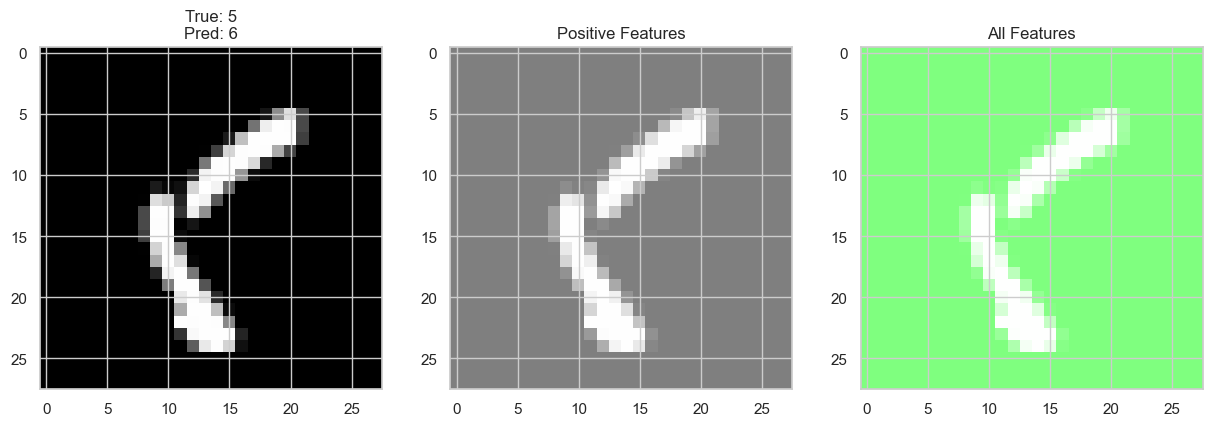

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


  2%|▏         | 20/1000 [00:00<00:06, 140.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  4%|▍         | 40/1000 [00:00<00:06, 138.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 60/1000 [00:00<00:06, 143.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 80/1000 [00:00<00:06, 136.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 10%|█         | 100/1000 [00:00<00:07, 114.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 11%|█         | 112/1000 [00:00<00:08, 108.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 12%|█▏        | 124/1000 [00:01<00:08, 107.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▎        | 135/1000 [00:01<00:08, 104.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▍        | 146/1000 [00:01<00:08, 103.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step


 16%|█▌        | 157/1000 [00:01<00:08, 94.49it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 17%|█▋        | 170/1000 [00:01<00:09, 86.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 19%|█▉        | 190/1000 [00:01<00:08, 99.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 21%|██        | 210/1000 [00:01<00:07, 108.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 23%|██▎       | 230/1000 [00:02<00:06, 114.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 25%|██▌       | 250/1000 [00:02<00:06, 122.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 27%|██▋       | 270/1000 [00:02<00:05, 123.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 29%|██▉       | 290/1000 [00:02<00:05, 127.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 31%|███       | 310/1000 [00:02<00:05, 128.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 33%|███▎      | 330/1000 [00:02<00:05, 130.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 35%|███▌      | 350/1000 [00:02<00:04, 131.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 37%|███▋      | 370/1000 [00:03<00:04, 133.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 39%|███▉      | 390/1000 [00:03<00:04, 134.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 41%|████      | 410/1000 [00:03<00:04, 130.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 43%|████▎     | 430/1000 [00:03<00:04, 127.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 45%|████▌     | 450/1000 [00:03<00:04, 123.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 47%|████▋     | 470/1000 [00:03<00:04, 122.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|████▉     | 490/1000 [00:04<00:04, 122.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 51%|█████     | 510/1000 [00:04<00:03, 123.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 53%|█████▎    | 530/1000 [00:04<00:03, 125.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 55%|█████▌    | 550/1000 [00:04<00:03, 127.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 57%|█████▋    | 570/1000 [00:04<00:03, 128.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 58%|█████▊    | 583/1000 [00:04<00:03, 128.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|██████    | 600/1000 [00:04<00:03, 121.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 62%|██████▏   | 620/1000 [00:05<00:03, 125.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 64%|██████▍   | 640/1000 [00:05<00:02, 129.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 660/1000 [00:05<00:02, 128.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 68%|██████▊   | 680/1000 [00:05<00:02, 130.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 700/1000 [00:05<00:02, 131.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 72%|███████▏  | 720/1000 [00:05<00:02, 133.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 74%|███████▍  | 740/1000 [00:05<00:01, 136.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 76%|███████▌  | 760/1000 [00:06<00:01, 132.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 78%|███████▊  | 780/1000 [00:06<00:01, 127.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 79%|███████▉  | 793/1000 [00:06<00:01, 124.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 81%|████████  | 810/1000 [00:06<00:01, 114.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 83%|████████▎ | 830/1000 [00:06<00:01, 117.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 85%|████████▌ | 850/1000 [00:06<00:01, 120.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 87%|████████▋ | 870/1000 [00:07<00:01, 122.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 890/1000 [00:07<00:00, 123.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 91%|█████████ | 910/1000 [00:07<00:00, 127.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 92%|█████████▏| 923/1000 [00:07<00:00, 125.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 94%|█████████▎| 936/1000 [00:07<00:00, 125.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▌| 950/1000 [00:07<00:00, 114.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 97%|█████████▋| 970/1000 [00:07<00:00, 118.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 99%|█████████▉| 990/1000 [00:08<00:00, 122.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|██████████| 1000/1000 [00:08<00:00, 122.67it/s]


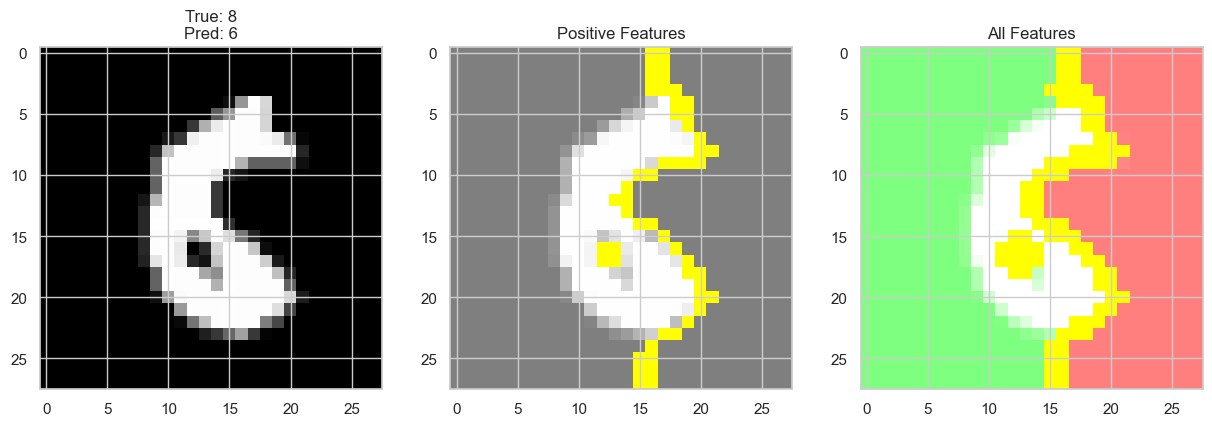

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  2%|▏         | 20/1000 [00:00<00:08, 121.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  4%|▍         | 40/1000 [00:00<00:07, 126.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  6%|▌         | 60/1000 [00:00<00:07, 133.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  8%|▊         | 80/1000 [00:00<00:07, 124.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 100/1000 [00:00<00:07, 122.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 12%|█▏        | 120/1000 [00:00<00:07, 124.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 14%|█▍        | 140/1000 [00:01<00:07, 121.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 16%|█▌        | 160/1000 [00:01<00:06, 124.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 18%|█▊        | 180/1000 [00:01<00:06, 124.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 20%|██        | 200/1000 [00:01<00:06, 127.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 22%|██▏       | 220/1000 [00:01<00:06, 127.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 24%|██▍       | 240/1000 [00:01<00:06, 122.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 26%|██▌       | 260/1000 [00:02<00:05, 127.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 28%|██▊       | 280/1000 [00:02<00:05, 127.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|███       | 300/1000 [00:02<00:05, 126.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 32%|███▏      | 320/1000 [00:02<00:05, 127.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 34%|███▍      | 340/1000 [00:02<00:05, 127.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 36%|███▌      | 360/1000 [00:02<00:05, 124.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 38%|███▊      | 380/1000 [00:03<00:04, 126.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|████      | 400/1000 [00:03<00:04, 125.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 41%|████▏     | 413/1000 [00:03<00:04, 126.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 43%|████▎     | 430/1000 [00:03<00:04, 120.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 45%|████▌     | 450/1000 [00:03<00:04, 124.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 47%|████▋     | 470/1000 [00:03<00:04, 124.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 49%|████▉     | 490/1000 [00:03<00:03, 128.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 510/1000 [00:04<00:03, 126.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 52%|█████▏    | 523/1000 [00:04<00:03, 123.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 54%|█████▎    | 536/1000 [00:04<00:03, 119.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 55%|█████▌    | 550/1000 [00:04<00:04, 107.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 57%|█████▋    | 570/1000 [00:04<00:03, 111.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 59%|█████▉    | 590/1000 [00:04<00:03, 116.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 61%|██████    | 610/1000 [00:04<00:03, 118.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 63%|██████▎   | 630/1000 [00:05<00:02, 126.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 65%|██████▌   | 650/1000 [00:05<00:02, 128.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 670/1000 [00:05<00:02, 128.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 69%|██████▉   | 690/1000 [00:05<00:02, 132.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 71%|███████   | 710/1000 [00:05<00:02, 134.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 730/1000 [00:05<00:01, 139.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 75%|███████▌  | 750/1000 [00:05<00:01, 136.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 77%|███████▋  | 770/1000 [00:06<00:01, 139.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 79%|███████▉  | 790/1000 [00:06<00:01, 138.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 81%|████████  | 810/1000 [00:06<00:01, 137.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 83%|████████▎ | 830/1000 [00:06<00:01, 142.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 84%|████████▍ | 845/1000 [00:06<00:01, 141.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 86%|████████▌ | 860/1000 [00:06<00:01, 122.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 88%|████████▊ | 880/1000 [00:06<00:00, 130.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|█████████ | 900/1000 [00:07<00:00, 131.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 92%|█████████▏| 920/1000 [00:07<00:00, 135.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 94%|█████████▍| 940/1000 [00:07<00:00, 132.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▌| 960/1000 [00:07<00:00, 136.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 98%|█████████▊| 980/1000 [00:07<00:00, 134.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


100%|██████████| 1000/1000 [00:07<00:00, 127.89it/s]


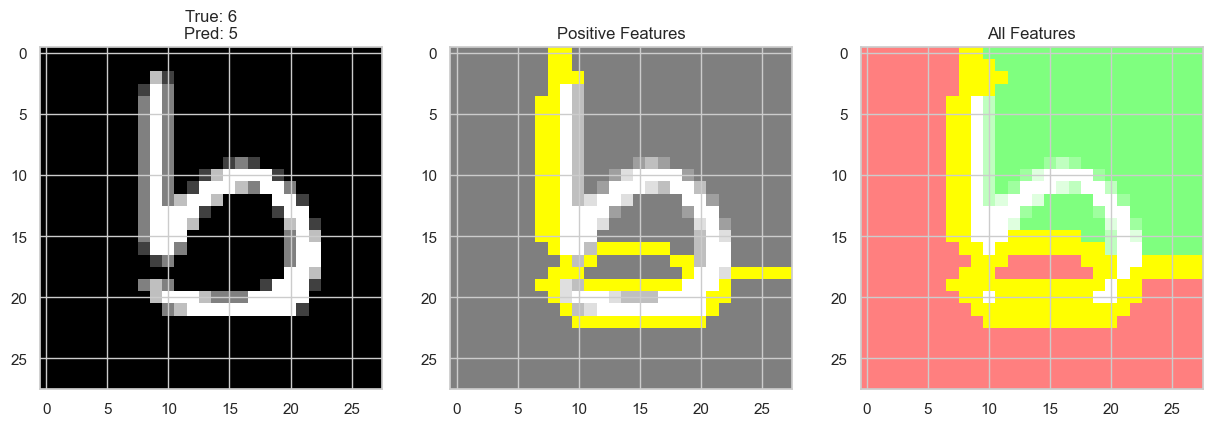

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  2%|▏         | 20/1000 [00:00<00:06, 159.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  4%|▍         | 40/1000 [00:00<00:06, 157.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


  6%|▌         | 60/1000 [00:00<00:06, 155.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  8%|▊         | 80/1000 [00:00<00:05, 158.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 100/1000 [00:00<00:05, 154.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 12%|█▏        | 120/1000 [00:00<00:05, 156.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 14%|█▍        | 140/1000 [00:00<00:05, 149.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 16%|█▌        | 160/1000 [00:01<00:05, 151.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 18%|█▊        | 180/1000 [00:01<00:05, 154.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 20%|██        | 200/1000 [00:01<00:05, 151.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 22%|██▏       | 220/1000 [00:01<00:05, 150.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 24%|██▍       | 240/1000 [00:01<00:04, 154.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 26%|██▌       | 260/1000 [00:01<00:04, 154.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 28%|██▊       | 280/1000 [00:01<00:04, 154.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 30%|███       | 300/1000 [00:01<00:04, 156.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 32%|███▏      | 320/1000 [00:02<00:04, 153.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 34%|███▍      | 340/1000 [00:02<00:04, 145.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 36%|███▌      | 360/1000 [00:02<00:04, 147.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 38%|███▊      | 380/1000 [00:02<00:04, 147.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 40%|████      | 400/1000 [00:02<00:03, 151.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 420/1000 [00:02<00:03, 152.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 44%|████▍     | 440/1000 [00:02<00:03, 154.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 46%|████▌     | 460/1000 [00:03<00:03, 155.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 48%|████▊     | 480/1000 [00:03<00:03, 156.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 500/1000 [00:03<00:03, 157.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 52%|█████▏    | 520/1000 [00:03<00:03, 157.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


 54%|█████▍    | 540/1000 [00:03<00:02, 157.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 56%|█████▌    | 560/1000 [00:03<00:02, 159.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 58%|█████▊    | 580/1000 [00:03<00:02, 156.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 60%|██████    | 600/1000 [00:03<00:02, 153.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 62%|██████▏   | 620/1000 [00:04<00:02, 153.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 64%|██████▍   | 640/1000 [00:04<00:02, 154.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 66%|██████▌   | 660/1000 [00:04<00:02, 154.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 68%|██████▊   | 680/1000 [00:04<00:02, 155.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 70%|███████   | 700/1000 [00:04<00:01, 151.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 720/1000 [00:04<00:01, 149.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 740/1000 [00:04<00:01, 147.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 76%|███████▌  | 760/1000 [00:04<00:01, 145.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 78%|███████▊  | 780/1000 [00:05<00:01, 137.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 80%|████████  | 800/1000 [00:05<00:01, 135.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 82%|████████▏ | 820/1000 [00:05<00:01, 137.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 840/1000 [00:05<00:01, 141.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 86%|████████▌ | 860/1000 [00:05<00:00, 145.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 88%|████████▊ | 880/1000 [00:05<00:00, 136.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 90%|█████████ | 900/1000 [00:05<00:00, 139.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 920/1000 [00:06<00:00, 141.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 940/1000 [00:06<00:00, 141.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 96%|█████████▌| 960/1000 [00:06<00:00, 142.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 98%|█████████▊| 980/1000 [00:06<00:00, 143.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


100%|██████████| 1000/1000 [00:06<00:00, 149.62it/s]


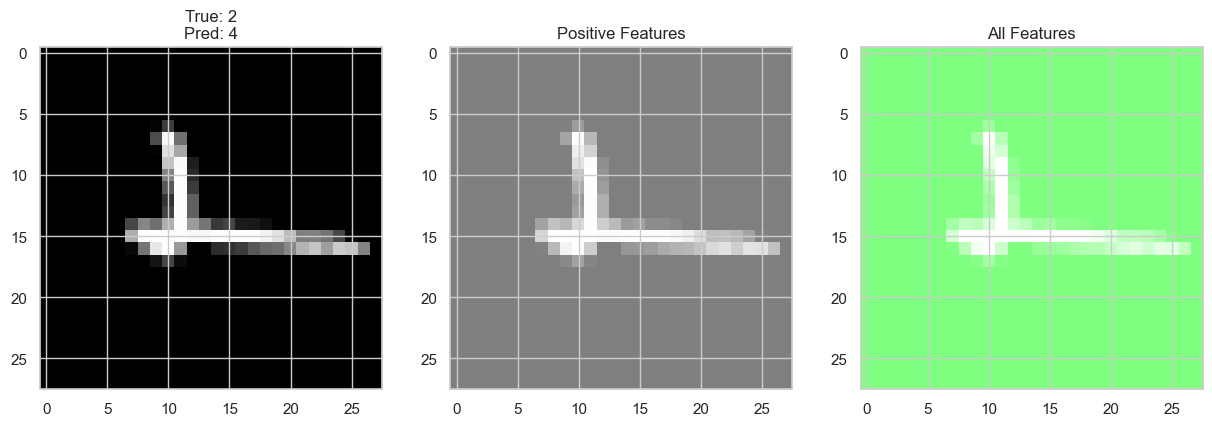

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


  1%|          | 10/1000 [00:00<00:11, 83.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  3%|▎         | 30/1000 [00:00<00:08, 117.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  5%|▌         | 50/1000 [00:00<00:07, 129.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


  7%|▋         | 70/1000 [00:00<00:07, 131.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  9%|▉         | 90/1000 [00:00<00:06, 139.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 11%|█         | 110/1000 [00:00<00:06, 143.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 13%|█▎        | 130/1000 [00:00<00:06, 132.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 15%|█▌        | 150/1000 [00:01<00:06, 134.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 17%|█▋        | 170/1000 [00:01<00:06, 132.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 18%|█▊        | 184/1000 [00:01<00:06, 131.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 20%|██        | 200/1000 [00:01<00:06, 121.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 22%|██▏       | 220/1000 [00:01<00:05, 130.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 24%|██▍       | 240/1000 [00:01<00:05, 135.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 26%|██▌       | 260/1000 [00:01<00:05, 131.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 28%|██▊       | 280/1000 [00:02<00:05, 134.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 30%|███       | 300/1000 [00:02<00:05, 138.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 32%|███▏      | 320/1000 [00:02<00:04, 142.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 34%|███▍      | 340/1000 [00:02<00:04, 140.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 360/1000 [00:02<00:04, 129.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 38%|███▊      | 380/1000 [00:02<00:04, 124.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


 40%|████      | 400/1000 [00:03<00:04, 128.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 42%|████▏     | 420/1000 [00:03<00:04, 131.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 44%|████▍     | 440/1000 [00:03<00:04, 133.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 46%|████▌     | 460/1000 [00:03<00:03, 136.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 48%|████▊     | 480/1000 [00:03<00:03, 135.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 50%|█████     | 500/1000 [00:03<00:03, 135.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 52%|█████▏    | 520/1000 [00:03<00:03, 125.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 54%|█████▍    | 540/1000 [00:04<00:03, 124.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 56%|█████▌    | 560/1000 [00:04<00:03, 120.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 58%|█████▊    | 580/1000 [00:04<00:03, 118.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 59%|█████▉    | 592/1000 [00:04<00:03, 114.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 610/1000 [00:04<00:03, 110.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 63%|██████▎   | 630/1000 [00:04<00:03, 113.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 65%|██████▌   | 650/1000 [00:05<00:02, 119.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 67%|██████▋   | 670/1000 [00:05<00:02, 122.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 69%|██████▉   | 690/1000 [00:05<00:02, 120.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 71%|███████   | 710/1000 [00:05<00:02, 124.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 73%|███████▎  | 730/1000 [00:05<00:02, 127.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 75%|███████▌  | 750/1000 [00:05<00:01, 130.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 76%|███████▋  | 764/1000 [00:05<00:01, 132.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 780/1000 [00:06<00:01, 125.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 80%|████████  | 800/1000 [00:06<00:01, 131.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 820/1000 [00:06<00:01, 129.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 83%|████████▎ | 833/1000 [00:06<00:01, 120.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 85%|████████▌ | 850/1000 [00:06<00:01, 115.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 87%|████████▋ | 870/1000 [00:06<00:01, 114.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 89%|████████▉ | 890/1000 [00:07<00:00, 118.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 91%|█████████ | 910/1000 [00:07<00:00, 124.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 93%|█████████▎| 930/1000 [00:07<00:00, 129.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 95%|█████████▌| 950/1000 [00:07<00:00, 134.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 97%|█████████▋| 970/1000 [00:07<00:00, 136.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 99%|█████████▉| 990/1000 [00:07<00:00, 137.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


100%|██████████| 1000/1000 [00:07<00:00, 128.13it/s]


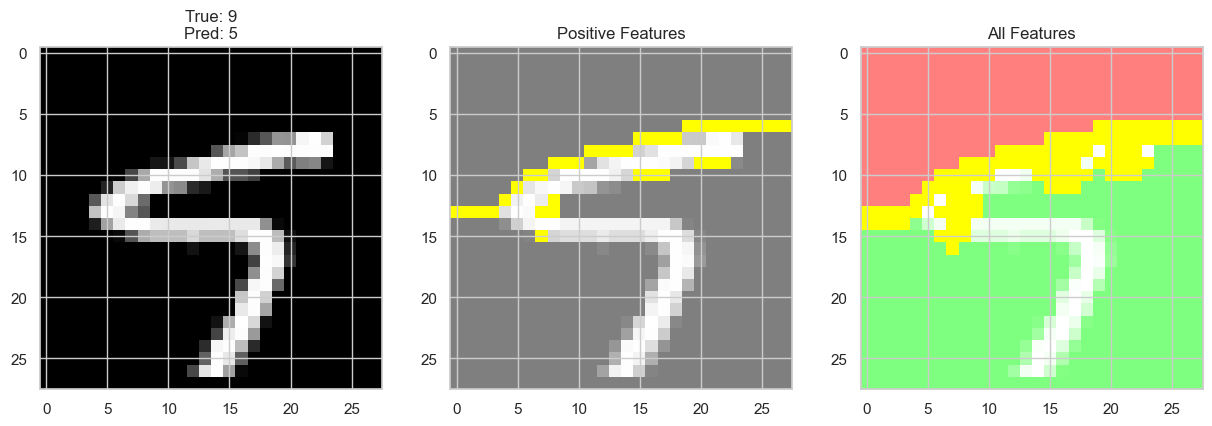

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  2%|▏         | 20/1000 [00:00<00:06, 147.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 40/1000 [00:00<00:06, 147.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


  6%|▌         | 60/1000 [00:00<00:06, 145.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  8%|▊         | 80/1000 [00:00<00:06, 139.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 100/1000 [00:00<00:06, 132.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 12%|█▏        | 120/1000 [00:00<00:06, 137.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 14%|█▍        | 140/1000 [00:01<00:06, 139.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 16%|█▌        | 160/1000 [00:01<00:06, 138.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 18%|█▊        | 180/1000 [00:01<00:05, 140.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 20%|██        | 200/1000 [00:01<00:05, 141.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 22%|██▏       | 220/1000 [00:01<00:05, 141.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 24%|██▍       | 240/1000 [00:01<00:05, 139.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 26%|██▌       | 260/1000 [00:01<00:05, 141.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 28%|██▊       | 280/1000 [00:01<00:05, 142.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 30%|███       | 300/1000 [00:02<00:04, 141.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 32%|███▏      | 320/1000 [00:02<00:04, 141.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 34%|███▍      | 340/1000 [00:02<00:04, 143.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 36%|███▌      | 360/1000 [00:02<00:04, 138.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 38%|███▊      | 380/1000 [00:02<00:04, 140.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 40%|████      | 400/1000 [00:02<00:04, 141.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 42%|████▏     | 420/1000 [00:02<00:04, 142.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 44%|████▍     | 440/1000 [00:03<00:03, 142.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 46%|████▌     | 460/1000 [00:03<00:03, 142.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 48%|████▊     | 480/1000 [00:03<00:03, 132.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 50%|█████     | 500/1000 [00:03<00:03, 129.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 52%|█████▏    | 520/1000 [00:03<00:03, 134.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 54%|█████▍    | 540/1000 [00:03<00:03, 137.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


 56%|█████▌    | 560/1000 [00:04<00:03, 140.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 58%|█████▊    | 580/1000 [00:04<00:02, 140.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 60%|██████    | 600/1000 [00:04<00:02, 136.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 620/1000 [00:04<00:02, 135.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 64%|██████▍   | 640/1000 [00:04<00:03, 114.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 65%|██████▌   | 653/1000 [00:04<00:03, 112.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 67%|██████▋   | 670/1000 [00:04<00:03, 109.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 690/1000 [00:05<00:02, 118.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 71%|███████   | 710/1000 [00:05<00:02, 120.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 73%|███████▎  | 730/1000 [00:05<00:02, 127.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 75%|███████▌  | 750/1000 [00:05<00:01, 130.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 77%|███████▋  | 770/1000 [00:05<00:01, 135.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 79%|███████▉  | 790/1000 [00:05<00:01, 136.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 810/1000 [00:05<00:01, 134.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 83%|████████▎ | 830/1000 [00:06<00:01, 136.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 85%|████████▌ | 850/1000 [00:06<00:01, 137.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 87%|████████▋ | 870/1000 [00:06<00:00, 139.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 89%|████████▉ | 890/1000 [00:06<00:00, 139.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 910/1000 [00:06<00:00, 128.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 93%|█████████▎| 930/1000 [00:06<00:00, 120.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 94%|█████████▍| 943/1000 [00:07<00:00, 121.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 96%|█████████▌| 956/1000 [00:07<00:00, 121.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 969/1000 [00:07<00:00, 122.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 982/1000 [00:07<00:00, 102.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 993/1000 [00:07<00:00, 103.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


100%|██████████| 1000/1000 [00:07<00:00, 131.35it/s]


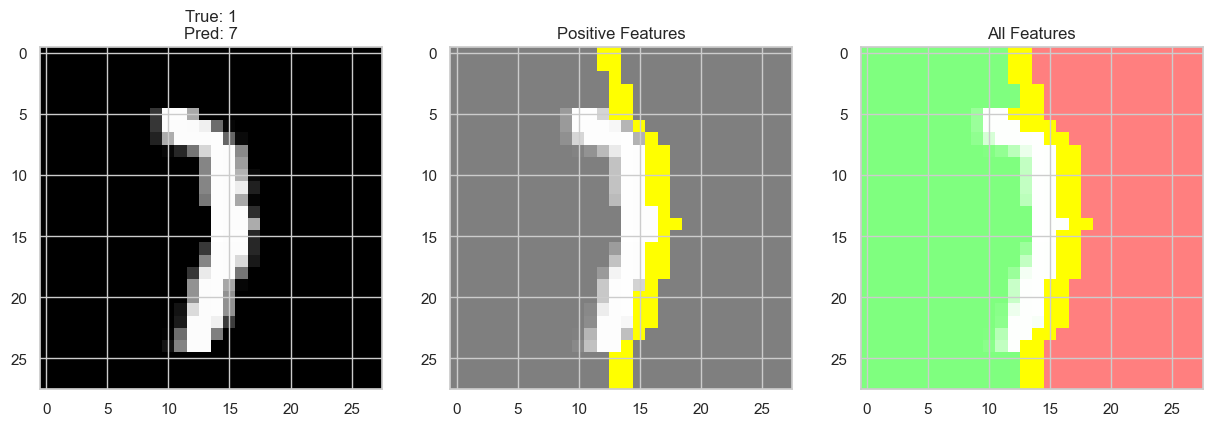

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


  2%|▏         | 20/1000 [00:00<00:07, 133.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


  4%|▍         | 40/1000 [00:00<00:06, 141.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 60/1000 [00:00<00:06, 139.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


  8%|▊         | 80/1000 [00:00<00:06, 140.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 10%|█         | 100/1000 [00:00<00:06, 139.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 12%|█▏        | 120/1000 [00:00<00:07, 120.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 140/1000 [00:01<00:07, 119.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|█▌        | 160/1000 [00:01<00:07, 117.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 18%|█▊        | 180/1000 [00:01<00:06, 118.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 20%|██        | 200/1000 [00:01<00:06, 117.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 22%|██▏       | 220/1000 [00:01<00:06, 112.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 23%|██▎       | 232/1000 [00:01<00:06, 113.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 24%|██▍       | 244/1000 [00:02<00:06, 112.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 26%|██▌       | 260/1000 [00:02<00:07, 102.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 28%|██▊       | 280/1000 [00:02<00:06, 108.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 30%|███       | 300/1000 [00:02<00:06, 109.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 32%|███▏      | 320/1000 [00:02<00:06, 113.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 33%|███▎      | 332/1000 [00:02<00:05, 114.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 35%|███▌      | 350/1000 [00:02<00:06, 108.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 370/1000 [00:03<00:05, 112.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 39%|███▉      | 390/1000 [00:03<00:05, 116.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 410/1000 [00:03<00:05, 117.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 43%|████▎     | 430/1000 [00:03<00:05, 113.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▌     | 450/1000 [00:03<00:04, 114.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 47%|████▋     | 470/1000 [00:04<00:04, 116.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 490/1000 [00:04<00:04, 117.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 51%|█████     | 510/1000 [00:04<00:04, 119.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 53%|█████▎    | 530/1000 [00:04<00:03, 122.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 54%|█████▍    | 543/1000 [00:04<00:03, 123.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 56%|█████▌    | 560/1000 [00:04<00:03, 113.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 58%|█████▊    | 580/1000 [00:04<00:03, 114.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|██████    | 600/1000 [00:05<00:03, 117.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 620/1000 [00:05<00:03, 115.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 64%|██████▍   | 640/1000 [00:05<00:03, 115.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 66%|██████▌   | 660/1000 [00:05<00:02, 119.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 672/1000 [00:05<00:03, 106.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 69%|██████▉   | 690/1000 [00:05<00:02, 107.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 70%|███████   | 701/1000 [00:06<00:02, 106.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 72%|███████▏  | 720/1000 [00:06<00:02, 101.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 74%|███████▍  | 740/1000 [00:06<00:02, 102.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 76%|███████▌  | 760/1000 [00:06<00:02, 109.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 780/1000 [00:06<00:01, 116.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 80%|████████  | 800/1000 [00:06<00:01, 119.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 82%|████████▏ | 820/1000 [00:07<00:01, 123.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 83%|████████▎ | 833/1000 [00:07<00:01, 121.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 85%|████████▌ | 850/1000 [00:07<00:01, 112.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 87%|████████▋ | 870/1000 [00:07<00:01, 114.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 88%|████████▊ | 882/1000 [00:07<00:01, 114.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 90%|█████████ | 900/1000 [00:07<00:00, 113.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 92%|█████████▏| 920/1000 [00:07<00:00, 117.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 94%|█████████▍| 940/1000 [00:08<00:00, 124.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 96%|█████████▌| 960/1000 [00:08<00:00, 128.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 98%|█████████▊| 980/1000 [00:08<00:00, 130.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


100%|██████████| 1000/1000 [00:08<00:00, 117.34it/s]


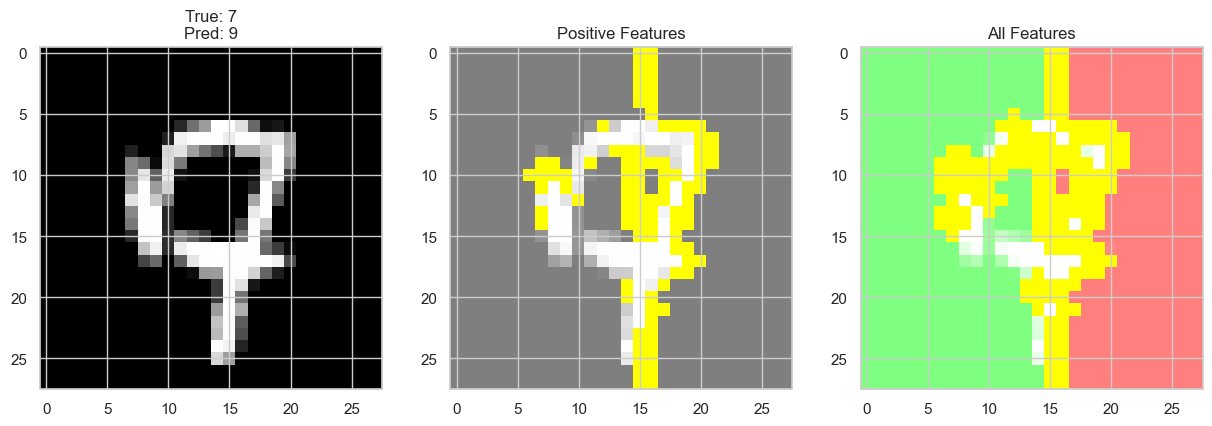

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


  2%|▏         | 20/1000 [00:00<00:07, 123.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  4%|▍         | 40/1000 [00:00<00:07, 131.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


  6%|▌         | 60/1000 [00:00<00:07, 133.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|▋         | 74/1000 [00:00<00:06, 133.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 88/1000 [00:00<00:06, 133.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step


 10%|█         | 102/1000 [00:00<00:08, 100.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 12%|█▏        | 120/1000 [00:01<00:09, 97.20it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 14%|█▍        | 140/1000 [00:01<00:08, 100.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▌        | 160/1000 [00:01<00:08, 103.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 171/1000 [00:01<00:07, 103.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▉        | 190/1000 [00:01<00:08, 99.40it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 20%|██        | 201/1000 [00:01<00:08, 98.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 22%|██▏       | 220/1000 [00:02<00:07, 99.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 24%|██▍       | 240/1000 [00:02<00:07, 101.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 25%|██▌       | 251/1000 [00:02<00:07, 97.34it/s] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 27%|██▋       | 270/1000 [00:02<00:07, 94.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 29%|██▉       | 290/1000 [00:02<00:07, 96.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 30%|███       | 300/1000 [00:02<00:07, 94.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 31%|███       | 310/1000 [00:03<00:07, 90.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 32%|███▏      | 320/1000 [00:03<00:07, 87.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 33%|███▎      | 330/1000 [00:03<00:07, 87.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


 34%|███▍      | 340/1000 [00:03<00:08, 79.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 35%|███▌      | 350/1000 [00:03<00:07, 81.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 370/1000 [00:03<00:06, 91.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 39%|███▉      | 390/1000 [00:03<00:06, 96.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████      | 410/1000 [00:04<00:05, 99.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 430/1000 [00:04<00:05, 106.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▌     | 450/1000 [00:04<00:05, 105.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 470/1000 [00:04<00:04, 108.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 490/1000 [00:04<00:04, 110.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 51%|█████     | 510/1000 [00:04<00:04, 114.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 530/1000 [00:05<00:04, 114.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 54%|█████▍    | 542/1000 [00:05<00:03, 114.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 56%|█████▌    | 560/1000 [00:05<00:04, 104.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 580/1000 [00:05<00:03, 106.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 59%|█████▉    | 591/1000 [00:05<00:03, 107.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 61%|██████    | 610/1000 [00:05<00:03, 102.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 62%|██████▏   | 621/1000 [00:06<00:03, 101.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 64%|██████▍   | 640/1000 [00:06<00:03, 104.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 660/1000 [00:06<00:03, 111.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 68%|██████▊   | 680/1000 [00:06<00:02, 115.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 70%|███████   | 700/1000 [00:06<00:02, 123.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


 72%|███████▏  | 720/1000 [00:06<00:02, 123.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 74%|███████▍  | 740/1000 [00:06<00:02, 128.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


 76%|███████▌  | 760/1000 [00:07<00:01, 131.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 78%|███████▊  | 780/1000 [00:07<00:01, 134.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 80%|████████  | 800/1000 [00:07<00:01, 137.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 82%|████████▏ | 820/1000 [00:07<00:01, 134.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 84%|████████▍ | 840/1000 [00:07<00:01, 137.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 86%|████████▌ | 860/1000 [00:07<00:01, 139.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 88%|████████▊ | 880/1000 [00:07<00:00, 138.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 90%|█████████ | 900/1000 [00:08<00:00, 138.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


 92%|█████████▏| 920/1000 [00:08<00:00, 135.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


 94%|█████████▍| 940/1000 [00:08<00:00, 137.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


 96%|█████████▌| 960/1000 [00:08<00:00, 138.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


 98%|█████████▊| 980/1000 [00:08<00:00, 140.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


100%|██████████| 1000/1000 [00:08<00:00, 113.03it/s]


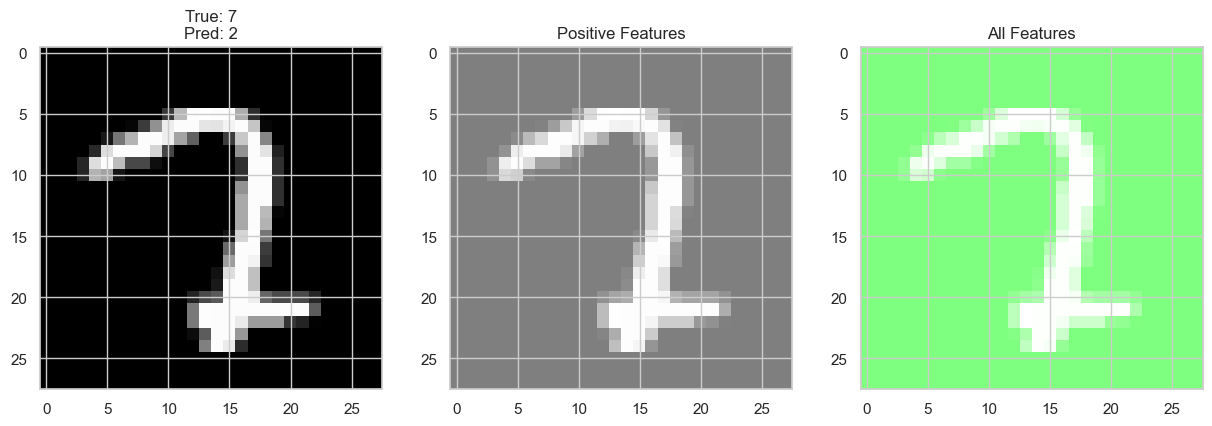

In [50]:
from skimage.segmentation import mark_boundaries
from lime import lime_image


lime_explainer = lime_image.LimeImageExplainer()

for i in id_10_greatest_differences_error_tests:
    # Convert to RGB
    img_rgb = to_rgb(error_tests[i])

    # Explain
    explanation = lime_explainer.explain_instance(
        img_rgb,
        model_predict,
        top_labels=5,
        hide_color=0,
        num_samples=1000
    )

    # Visualization
    plt.figure(figsize=(15, 5))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(error_tests[i], cmap='gray')
    plt.title(f"True: {true_label_error_tests[i]}\nPred: {pred_label_error_tests[i]}")

    # LIME Explanation (Positive)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=10,
        hide_rest=True
    )
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title("Positive Features")

    # LIME Explanation (All)
    temp, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=False,
        num_features=10,
        hide_rest=True
    )
    plt.subplot(1, 3, 3)
    plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
    plt.title("All Features")

    plt.show()

In [51]:
model.layers[0].input 

<KerasTensor shape=(None, 28, 28, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [52]:
model.summary()  # Verify layer names

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,633,920 (25.31 MB)

 Trainable params: 2,210,154 (8.43 MB)

 Non-trainable params: 3,456 (13.50 KB)

 Optimizer params: 4,420,310 (16.86 MB)

### GradCAM (Gradient-weighted Class Activation Mapping)

In [53]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense

def build_functional_model():
    inputs = Input(shape=(28, 28, 1))

    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    last_conv_output = Conv2D(64, (3, 3), activation='relu', padding='same', name='last_conv')(x)
    x = BatchNormalization()(last_conv_output)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(10, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

In [54]:
model_for_grad = build_functional_model()
model_for_grad.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_for_grad.fit(
    datagen.flow(x_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(x_test, y_test),
    verbose=1,
    steps_per_epoch=x_train.shape[0] // batch_size,
    callbacks=[reduce_lr]
)  # Train it if not already trained




Epoch 1/10


c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


590/590 ━━━━━━━━━━━━━━━━━━━━ 42s 64ms/step - accuracy: 0.7869 - loss: 0.7637 - val_accuracy: 0.9307 - val_loss: 0.2218 - learning_rate: 0.0010
Epoch 2/10
  1/590 ━━━━━━━━━━━━━━━━━━━━ 30s 52ms/step - accuracy: 0.9219 - loss: 0.3316

c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9219 - loss: 0.3316 - val_accuracy: 0.9417 - val_loss: 0.1856 - learning_rate: 9.0000e-04
Epoch 3/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 37s 63ms/step - accuracy: 0.9567 - loss: 0.1397 - val_accuracy: 0.9771 - val_loss: 0.0859 - learning_rate: 8.1000e-04
Epoch 4/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9844 - loss: 0.0848 - val_accuracy: 0.9764 - val_loss: 0.0877 - learning_rate: 7.2900e-04
Epoch 5/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - accuracy: 0.9703 - loss: 0.0983 - val_accuracy: 0.9917 - val_loss: 0.0315 - learning_rate: 6.5610e-04
Epoch 6/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9688 - loss: 0.0881 - val_accuracy: 0.9917 - val_loss: 0.0311 - learning_rate: 5.9049e-04
Epoch 7/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 35s 60ms/step - accuracy: 0.9755 - loss: 0.0765 - val_accuracy: 0.9881 - val_loss: 0.0419 - learning_rate: 5.3144e-04
Epoch 8/10
590/590 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.968

In [55]:
# Print layer names to identify the last Conv2D layer
for idx, layer in enumerate(model_for_grad.layers):
    print(f"{idx}: {layer.name}")


0: input_layer_1
1: conv2d_4
2: batch_normalization_6
3: conv2d_5
4: batch_normalization_7
5: max_pooling2d_2
6: dropout_4
7: conv2d_6
8: batch_normalization_8
9: last_conv
10: batch_normalization_9
11: max_pooling2d_3
12: dropout_5
13: flatten_1
14: dense_3
15: batch_normalization_10
16: dropout_6
17: dense_4
18: batch_normalization_11
19: dropout_7
20: dense_5


In [56]:
last_conv_layer_name = 'last_conv'  # Update this based on your model

In [ ]:
print(model_for_grad.input_shape)

(None, 28, 28, 1)


In [214]:
#input_images_grad = error_tests[1:7]
indices = np.random.choice(len(x_test), size=3, replace=False)
input_images_grad = x_test[21:51].reshape(-1, 28, 28, 1)
predictions_for_grad = model_for_grad.predict(input_images_grad)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [215]:
input_images_grad.shape

(30, 28, 28, 1)

In [216]:
import tensorflow as tf

# Assume 'model' is your CNN and 'target_layer_name' is the name of the last conv layer.
target_layer = model_for_grad.get_layer(last_conv_layer_name)
grad_model = tf.keras.models.Model(
    inputs=model_for_grad.input,  # Access via first layer
    outputs=[target_layer.output, model_for_grad.output]
)


In [217]:
def compute_gradcam2(input_image, class_idx):
    input_image = tf.convert_to_tensor(input_image)
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(input_image)
        loss = predictions[:, class_idx]
    grads = tape.gradient(loss, conv_outputs)
    return conv_outputs, grads, predictions

In [209]:
def compute_gradcam(input_image, class_idx):
    input_image = tf.convert_to_tensor(input_image)  # Ensure it's a tensor
    with tf.GradientTape() as tape:
        tape.watch(input_image)  # Explicitly watch the input
        conv_outputs, predictions = grad_model(input_image)
        loss = predictions[:, class_idx]  # score for the target class
    grads = tape.gradient(loss, conv_outputs)
    return conv_outputs, grads, predictions


In [218]:
import numpy as np

def generate_heatmap(conv_outputs, grads):
    # Compute the channel-wise mean of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(1, 2))

    # Multiply each channel in the feature map array by the corresponding weight
    conv_outputs = conv_outputs[0]  # assuming batch size of 1
    pooled_grads = pooled_grads[0]
    heatmap = conv_outputs * tf.reshape(pooled_grads, (1, 1, -1))
    
    # Sum the weighted channels to obtain the heatmap
    heatmap = tf.reduce_sum(heatmap, axis=-1)
    heatmap = tf.maximum(heatmap, 0)  # apply ReLU
    heatmap /= tf.reduce_max(heatmap) + 1e-10  # normalize
    return heatmap.numpy()


In [219]:
print("predictions_for_grad shape:", predictions_for_grad.shape)
print("predictions_for_grad:", predictions_for_grad)


predictions_for_grad shape: (30, 10)
predictions_for_grad: [[2.78447110e-09 6.05962546e-12 1.82302418e-09 1.57025659e-09
  1.72143643e-07 1.60665425e-09 8.02470382e-11 2.80256273e-07
  2.54479744e-07 9.99999285e-01]
 [1.64397932e-07 1.68045500e-09 4.68341064e-08 6.48177467e-09
  8.39938366e-07 3.68632858e-09 3.05285175e-09 2.75152388e-06
  4.63259909e-07 9.99995708e-01]
 [1.11603241e-10 1.24253874e-09 2.51393550e-09 7.76675599e-11
  9.99999881e-01 4.18209134e-10 6.46914211e-09 7.34592343e-09
  7.41739947e-10 6.31615507e-08]
 [9.99996066e-01 9.15890386e-09 1.32087905e-07 2.23063179e-10
  1.77795521e-08 1.45727469e-07 1.66232053e-06 1.05336589e-07
  1.54595216e-06 3.39011706e-07]
 [1.20088389e-05 4.00386807e-06 1.29313136e-07 2.61493660e-05
  1.68270972e-02 2.64390446e-02 1.15094204e-04 6.24920009e-04
  1.09315251e-05 9.55940664e-01]
 [9.99929190e-01 1.08813275e-07 3.15370158e-07 1.34848491e-07
  7.21967481e-08 3.26620949e-07 3.85353014e-05 8.27558324e-08
  7.17681178e-06 2.40317113e-05]

In [220]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def overlay_heatmap(heatmap, original_image, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    
    if original_image.shape[-1] == 1:
        original_image = cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR)
    
    overlayed = cv2.addWeighted(original_image, 1 - alpha, heatmap, alpha, 0)
    return overlayed

def show_gradcam_grid(images, model, grad_model, compute_gradcam_func, cols=3):
    num_images = len(images)
    rows = (num_images + cols - 1) // cols

    plt.figure(figsize=(cols * 4, rows * 4))
    
    for i in range(num_images):
        input_image = np.expand_dims(images[i], axis=0)
        preds = model.predict(input_image)
        class_idx = np.argmax(preds[0])
        
        conv_outputs, grads, _ = compute_gradcam_func(input_image, class_idx)
        heatmap = generate_heatmap(conv_outputs, grads)
        overlayed = overlay_heatmap(heatmap, (images[i] * 255).astype(np.uint8))

        plt.subplot(rows, cols, i + 1)
        plt.imshow(cv2.cvtColor(overlayed, cv2.COLOR_BGR2RGB))
        plt.title(f"Class: {class_idx}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━

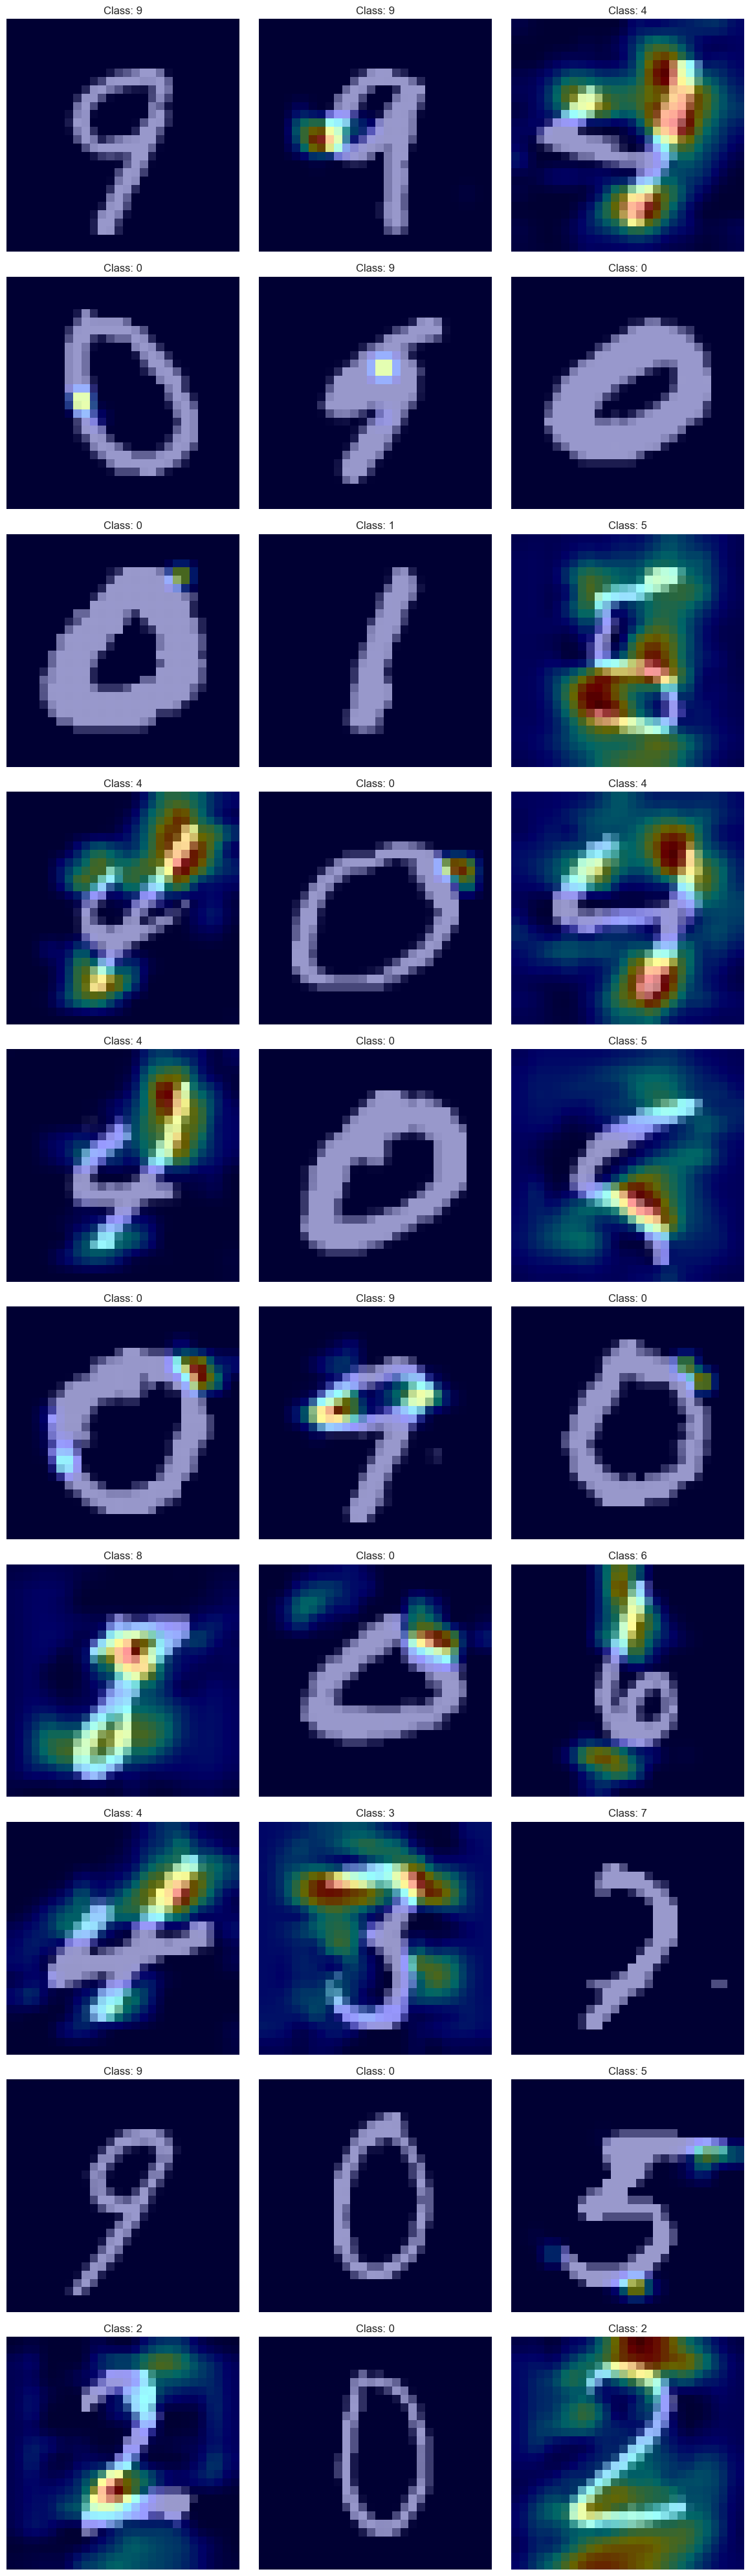

In [221]:
show_gradcam_grid(
    images=input_images_grad,  # shape (6, 28, 28, 1)
    model=model_for_grad,
    grad_model=grad_model,
    compute_gradcam_func=compute_gradcam2,  # your existing Grad-CAM logic
    cols=3  # customize layout
)

## Output prediction to CSV file

In [123]:
pred_digits_test = np.argmax(model.predict(df_test),axis=1)
image_id_test = []

for i in range (len(pred_digits_test)):
    image_id_test.append(i+1)

d = {'ImageId':image_id_test,'Label':pred_digits_test}
answer = pd.DataFrame(d)

answer.to_csv('answer.csv',index=False)

875/875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


# Building KNN MODEL

### Reprocessing Data for KNN

In [124]:
# Separate features and labels
X = train.iloc[:, 1:].values  # Pixels
Y = train.iloc[:, 0].values  # Labels

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

# Normalize the pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0
test_data = test.values / 255.0

### Training model

In [125]:
# Define the updated parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7],  # Reduced to 3 values
    'weights': ['uniform'],     # Keeping only one option for simplicity
    'metric': ['euclidean']     # Keeping only one metric for simplicity
}

# Initialize the KNN model
knn = KNeighborsClassifier()

# Perform Grid Search with Cross-Validation
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found:", best_params)

# Train the model with the best parameters
best_knn = KNeighborsClassifier(**best_params)
best_knn.fit(x_train, y_train)

# Evaluate the model on the test set
y_pred = best_knn.predict(x_test)
print("Accuracy on test set with best parameters:", accuracy_score(y_test, y_pred))

# Predict on the test data
pred_digits_test = best_knn.predict(test_data)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters found: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
Accuracy on test set with best parameters: 0.9709523809523809


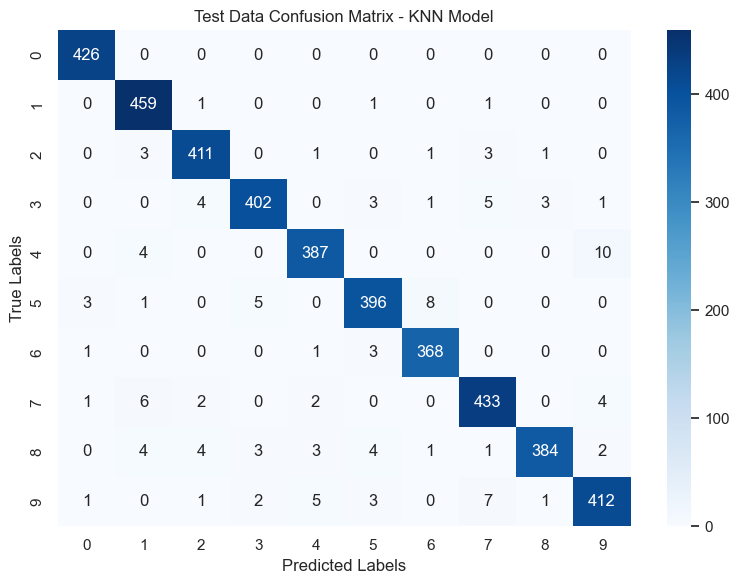

In [126]:
# If y_test is one-hot encoded, convert it to a single-label format
if len(y_test.shape) > 1:
    y_test = np.argmax(y_test, axis=1)

# Generate confusion matrix
test_conf_matrix = confusion_matrix(y_test, y_pred)

# Plotting the confusion matrix for the test data
plt.figure(figsize=(8, 6))
sns.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Test Data Confusion Matrix - KNN Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()


# Building MLP MODEL

### Reprocessing Data for MLP

In [127]:
# Prepare training and test data
X = train.iloc[:, 1:]
Y = train.iloc[:, 0]

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=seed)

# Normalize the data
x_train = x_train.values.astype("float32") / 255
x_test = x_test.values.astype("float32") / 255
df_test = test.values.astype("float32") / 255

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [128]:
# Define the MLP model
model = Sequential()

# Input layer
model.add(Dense(512, activation='relu', input_shape=(784,)))
model.add(Dropout(0.2))

# Hidden layers
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))

# Output layer
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train,
                    validation_data=(x_test, y_test),
                    epochs=50,
                    batch_size=128,
                    callbacks=[early_stopping],
                    verbose=2)

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")

Epoch 1/50


c:\Users\Mohamed Aziz\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


296/296 - 3s - 9ms/step - accuracy: 0.8866 - loss: 0.3726 - val_accuracy: 0.9481 - val_loss: 0.1717
Epoch 2/50
296/296 - 2s - 6ms/step - accuracy: 0.9554 - loss: 0.1442 - val_accuracy: 0.9607 - val_loss: 0.1426
Epoch 3/50
296/296 - 2s - 5ms/step - accuracy: 0.9676 - loss: 0.1040 - val_accuracy: 0.9650 - val_loss: 0.1181
Epoch 4/50
296/296 - 2s - 6ms/step - accuracy: 0.9748 - loss: 0.0800 - val_accuracy: 0.9698 - val_loss: 0.1001
Epoch 5/50
296/296 - 2s - 6ms/step - accuracy: 0.9791 - loss: 0.0656 - val_accuracy: 0.9733 - val_loss: 0.0947
Epoch 6/50
296/296 - 2s - 6ms/step - accuracy: 0.9837 - loss: 0.0508 - val_accuracy: 0.9733 - val_loss: 0.0954
Epoch 7/50
296/296 - 2s - 5ms/step - accuracy: 0.9848 - loss: 0.0475 - val_accuracy: 0.9738 - val_loss: 0.1091
Epoch 8/50
296/296 - 2s - 5ms/step - accuracy: 0.9854 - loss: 0.0456 - val_accuracy: 0.9757 - val_loss: 0.1026
Epoch 9/50
296/296 - 2s - 5ms/step - accuracy: 0.9872 - loss: 0.0380 - val_accuracy: 0.9743 - val_loss: 0.0998
Epoch 10/50


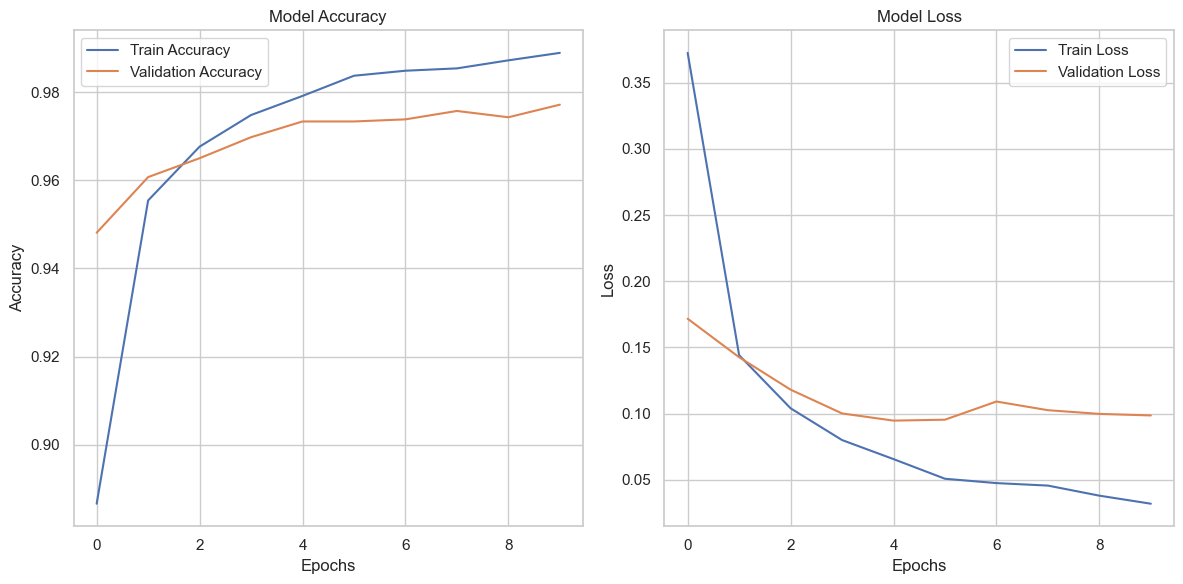

In [129]:
# Plotting the accuracy curve
plt.figure(figsize=(12, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

1182/1182 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


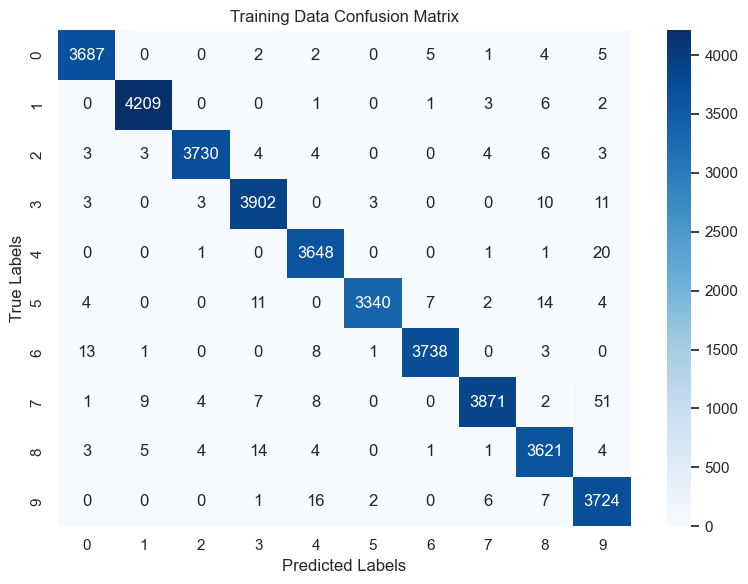

In [130]:
# Get predictions for the training set
y_train_pred = np.argmax(model.predict(x_train), axis=1)

# Convert categorical labels back to single digits
y_train_true = np.argmax(y_train, axis=1)

# Generate confusion matrix
train_conf_matrix = confusion_matrix(y_train_true, y_train_pred)

# Plotting the confusion matrix for training data
plt.figure(figsize=(8, 6))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(10), yticklabels=np.arange(10))
plt.title('Training Data Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

plt.tight_layout()
plt.show()

# Conclusion

After evaluating three machine learning methods—Convolutional Neural Networks (CNN), Multi-Layer Perceptron (MLP), and K-Nearest Neighbors (KNN)—on the classification task, it is clear that CNN was the most effective model. Here's a comparison of the results:

1. **CNN**: The CNN model achieved the best performance with high accuracy (around 99.55% on the test set). It showed a stable learning curve with significant improvements in both training and validation accuracy across epochs. The CNN architecture is well-suited for image classification tasks, as it can effectively capture spatial hierarchies and patterns in the data, leading to robust feature extraction and generalization.

2. **MLP**: While the MLP model also performed well with accuracy values around 98% on the validation set, it lagged slightly behind the CNN. MLPs typically require extensive tuning and might not capture spatial features as effectively as CNNs, especially in image-related tasks.

3. **KNN**: The KNN classifier showed acceptable performance but fell short in comparison to CNN. KNN relies on the distance between instances for classification, which can be computationally expensive for large datasets, and it doesn't benefit from the hierarchical feature extraction process that CNNs provide.

### Why CNN Performed the Best:
- **Feature Extraction**: CNNs excel at automatically extracting hierarchical features from images, which is a crucial advantage in image classification tasks like digit recognition.
- **Generalization**: CNNs tend to generalize better compared to traditional machine learning algorithms like KNN and MLP when dealing with image data.
- **Overfitting Control**: By using data augmentation techniques such as rotation, flipping, and zooming, CNNs can prevent overfitting, a problem that might be more pronounced in MLP or KNN models, especially on small datasets.

Thus, for image classification tasks, CNN proved to be the most powerful method due to its ability to learn from raw pixel data and capture spatial relationships more effectively than other models.